In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from elementwise import rmsle

In [2]:
def back_testing(data):
    tickers_dict_r_min = {}
    tickers_dict_r_max = {}
    tickers_dict_f_min = {}
    tickers_dict_f_max = {}
    ds = data.groupby('event_id')
    for i in ds:
        mean_max = i[1]['prediction_max'].values.mean()
        mean_min = i[1]['prediction_min'].values.mean()
        real_max = i[1]['real_max'].values.mean()
        real_min = i[1]['real_min'].values.mean()
        ticker = 'c5e2ca55-3606-40ad-aae5-55be180a7de5'  # i[1]['ticker_id'][0]
        if ticker not in tickers_dict_r_min.keys():
            tickers_dict_r_min[ticker] = []
        if ticker not in tickers_dict_r_max.keys():
            tickers_dict_r_max[ticker] = []
        if ticker not in tickers_dict_f_min.keys():
            tickers_dict_f_min[ticker] = []
        if ticker not in tickers_dict_f_max.keys():
            tickers_dict_f_max[ticker] = []
        tickers_dict_r_min[ticker].append(real_min)
        tickers_dict_r_max[ticker].append(real_max)
        tickers_dict_f_min[ticker].append(mean_min)
        tickers_dict_f_max[ticker].append(mean_max)

    result_min = {}
    result_max = {}

    for ticker in tickers_dict_r_min.keys():
        rmsle_min = rmsle(tickers_dict_r_min[ticker], tickers_dict_f_min[ticker])
        rmsle_max = rmsle(tickers_dict_r_max[ticker], tickers_dict_f_max[ticker])
        result_min[ticker] = rmsle_min
        result_max[ticker] = rmsle_max

    res_min = np.mean(list(result_min.values()))
    res_max = np.mean(list(result_max.values()))
    print(res_min)
    print(res_max)

In [80]:
ticker = 'c5e2ca55-3606-40ad-aae5-55be180a7de5'

/usr/local/lib/python3.5/dist-packages/pandas/indexes/range.py:432: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  return self._int64index.union(other)


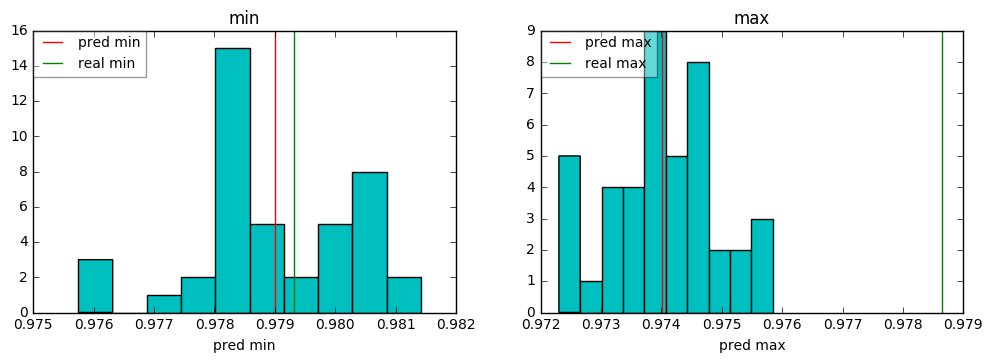

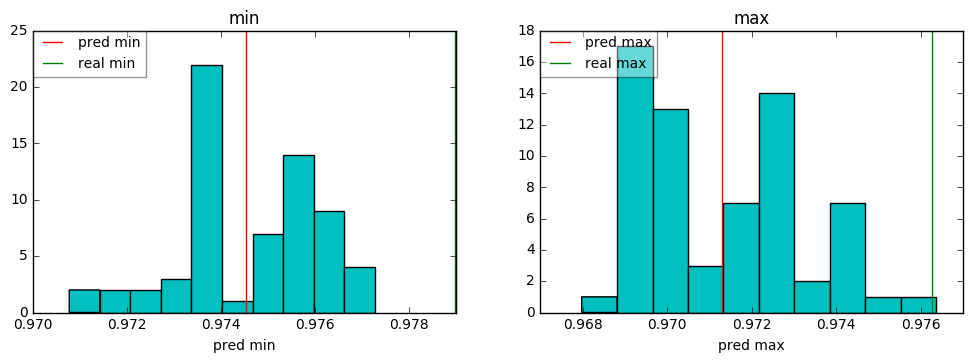

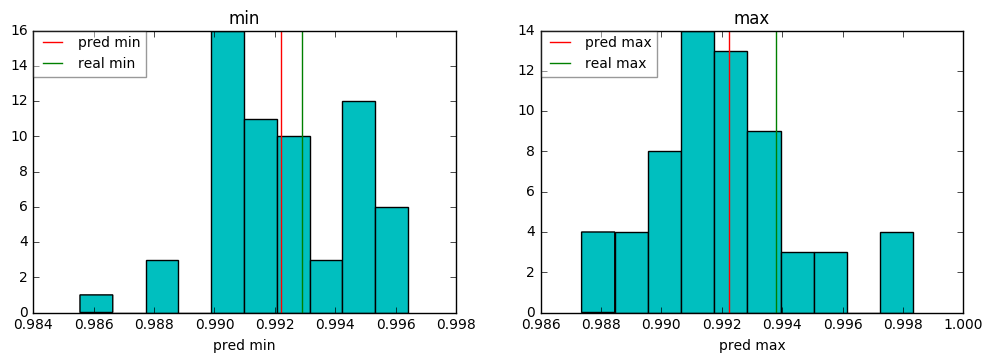

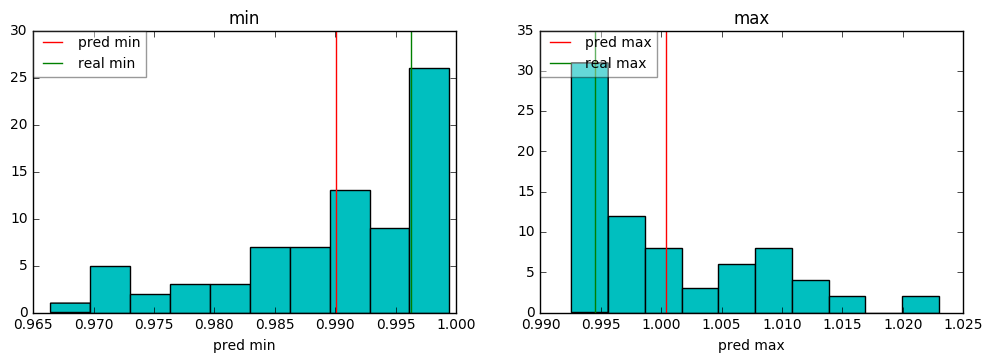

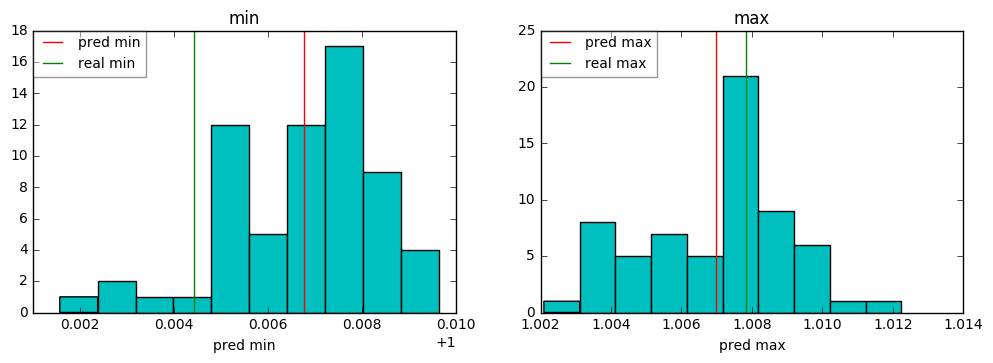

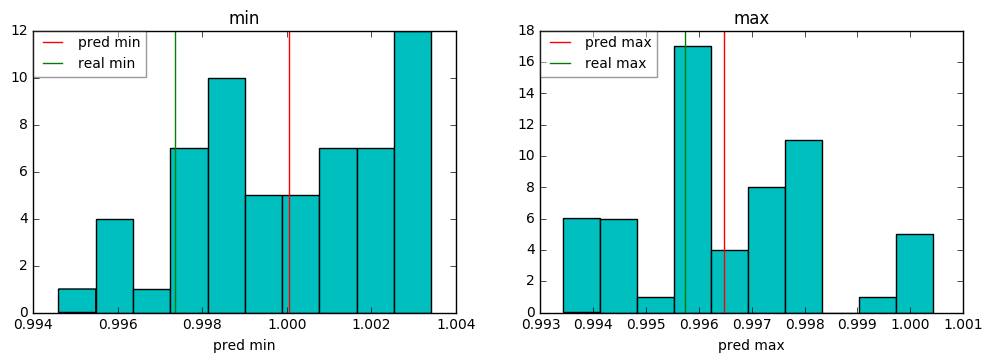

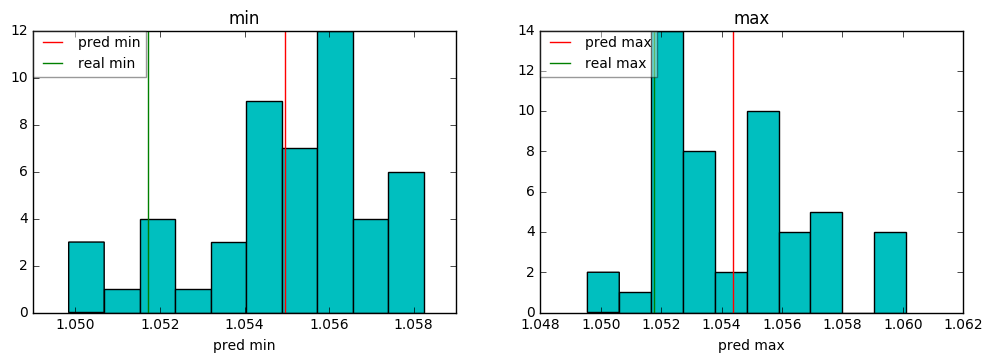

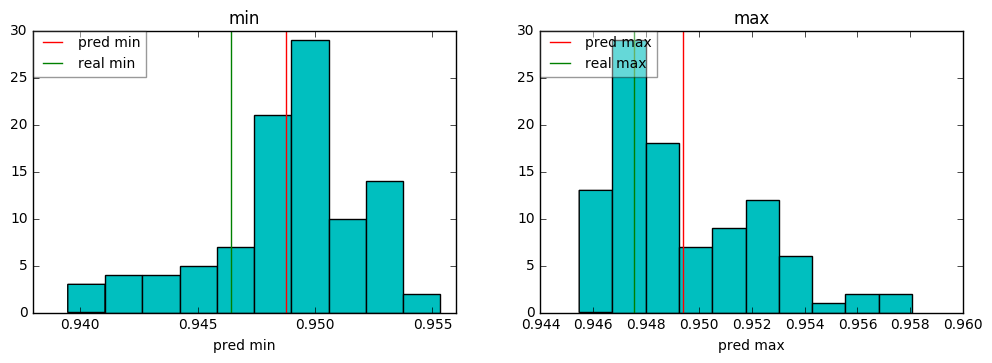

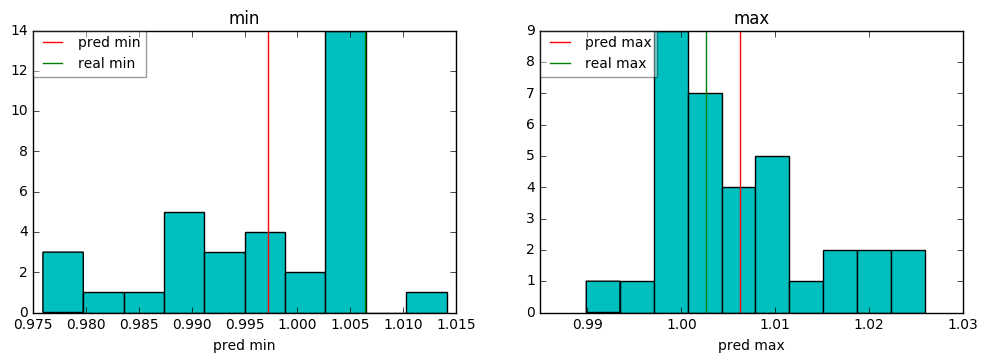

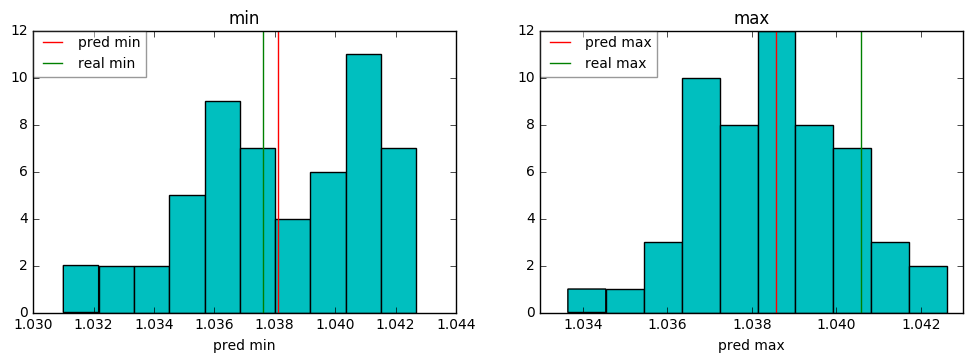

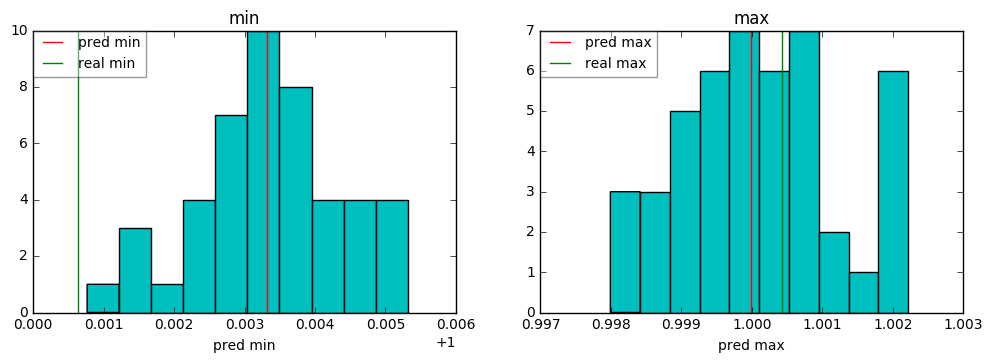

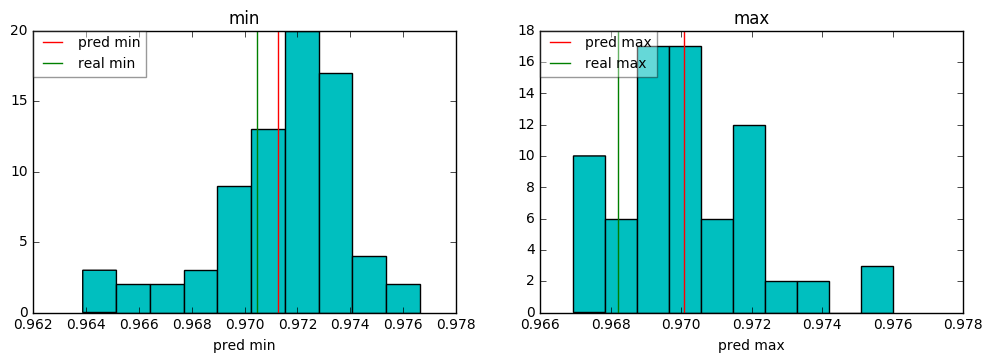

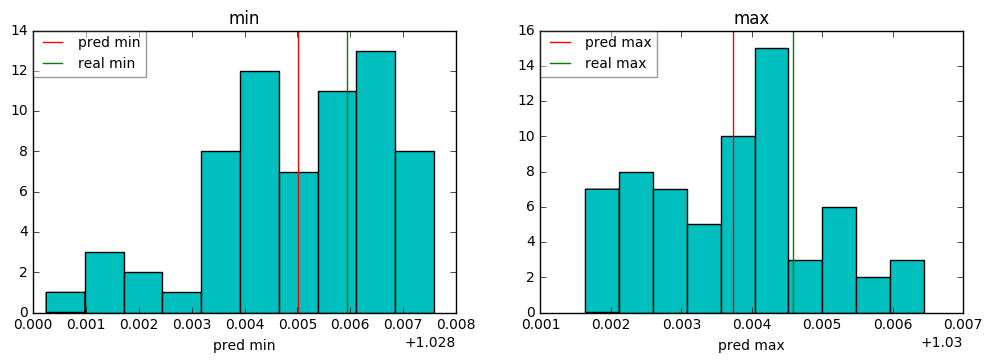

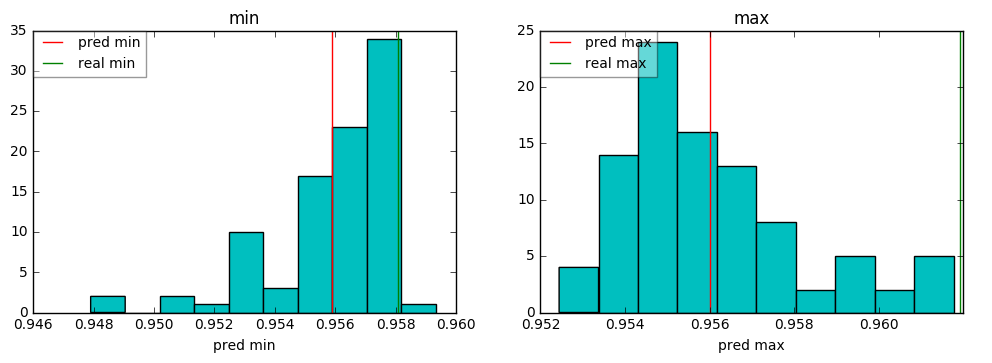

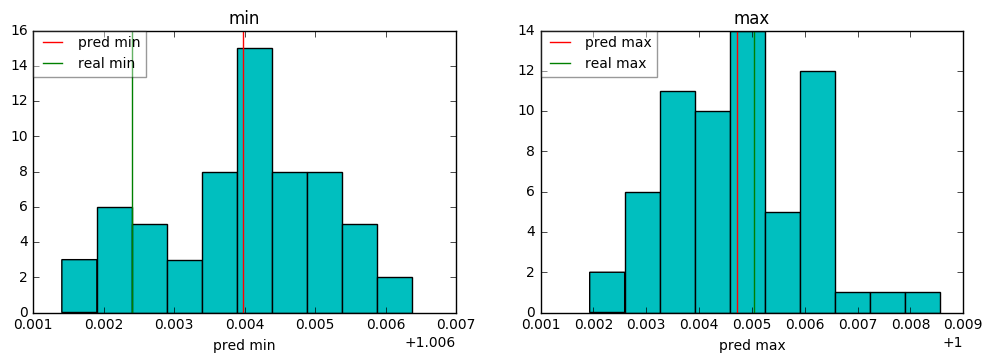

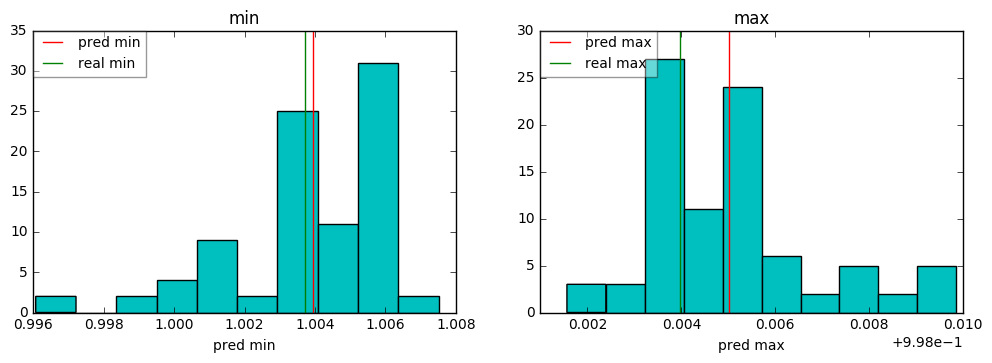

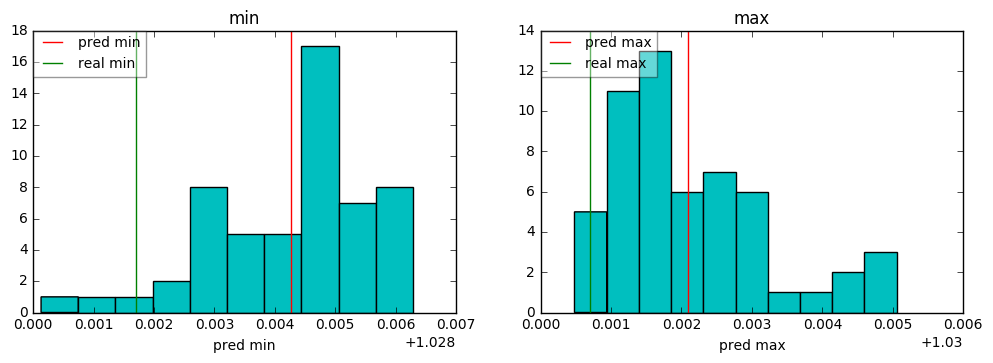

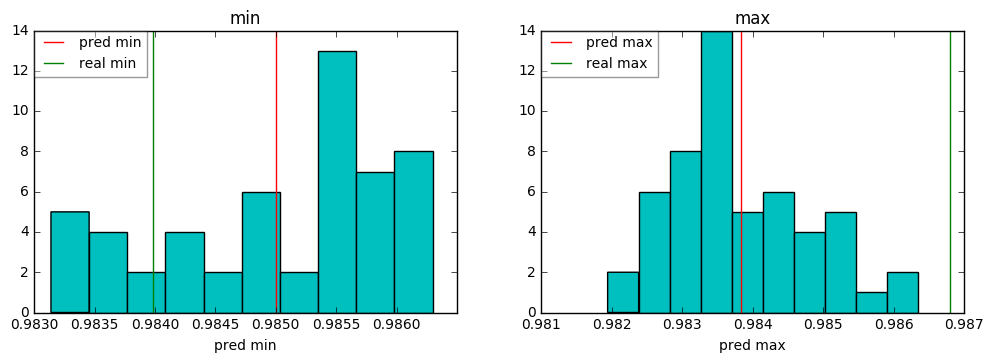

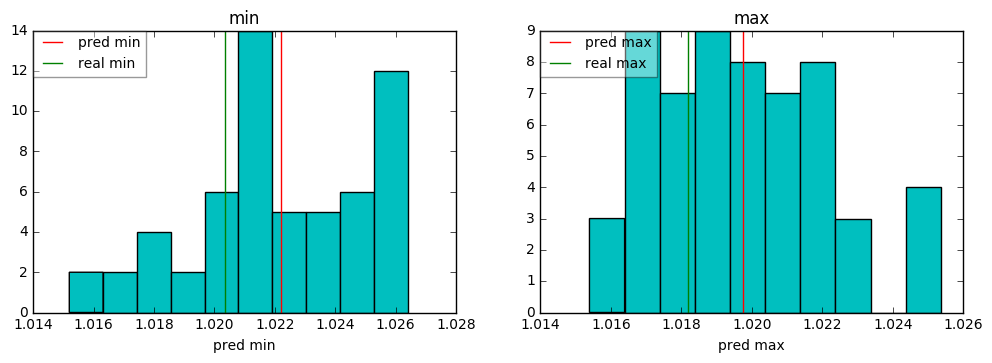

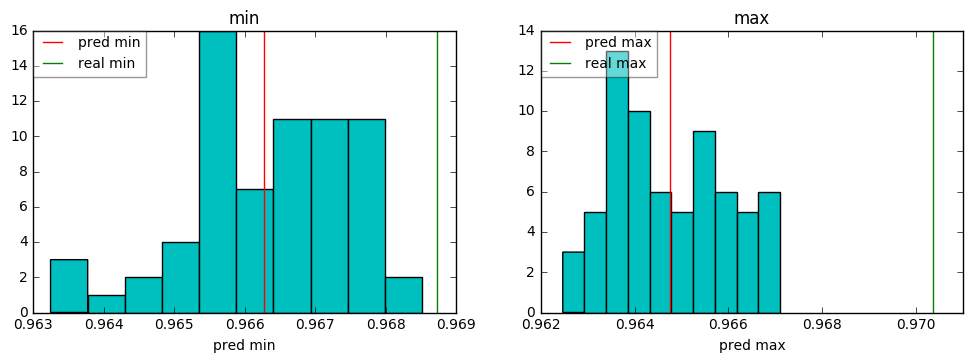

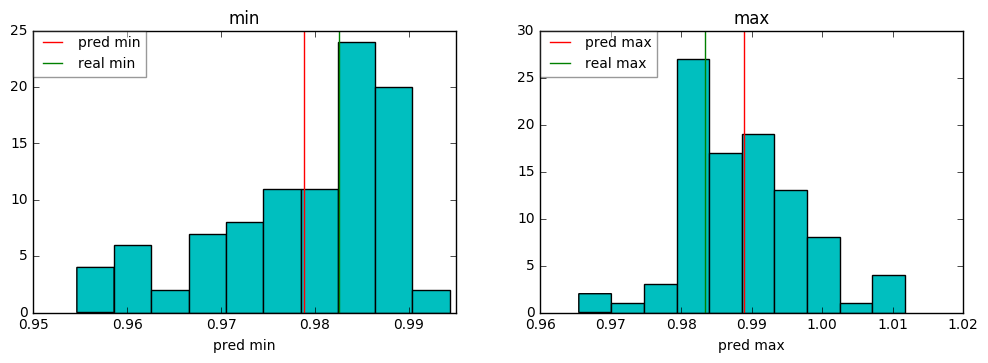

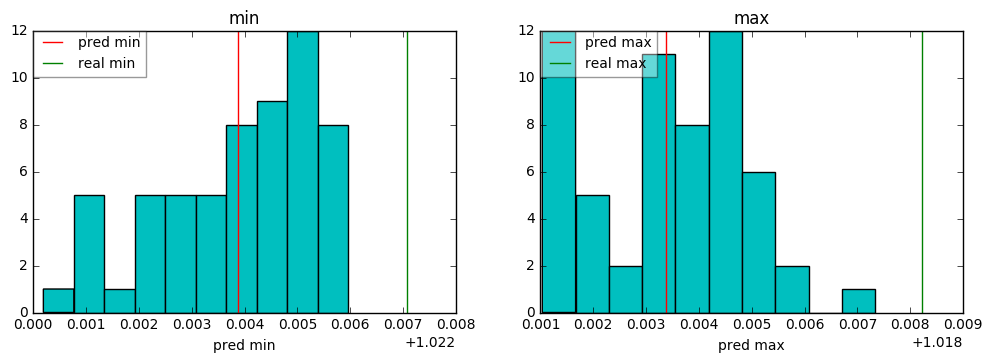

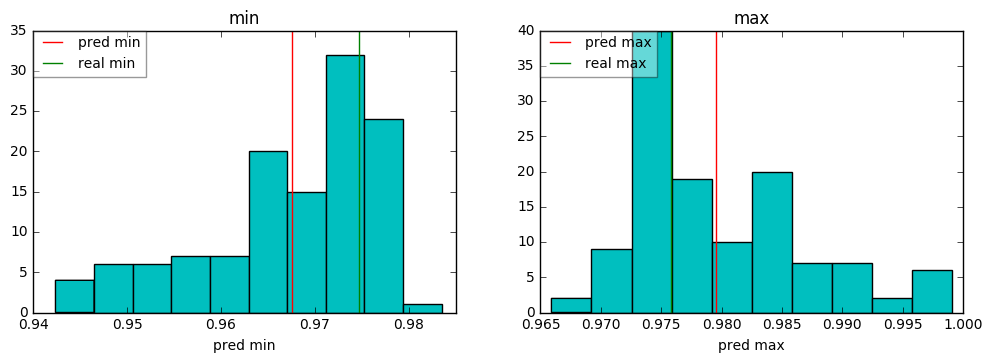

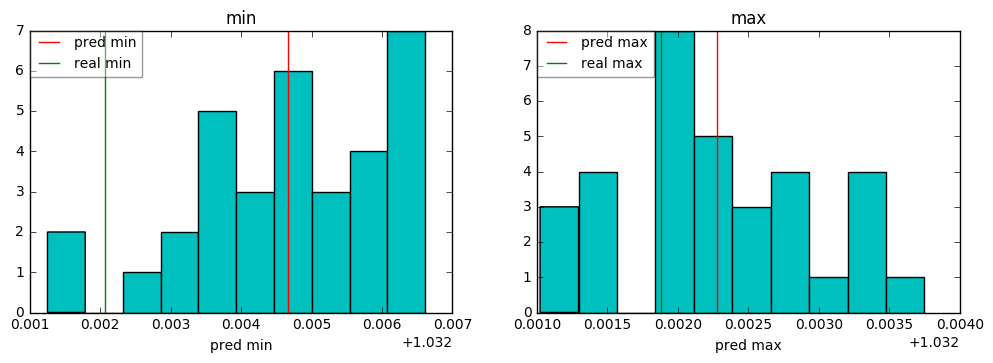

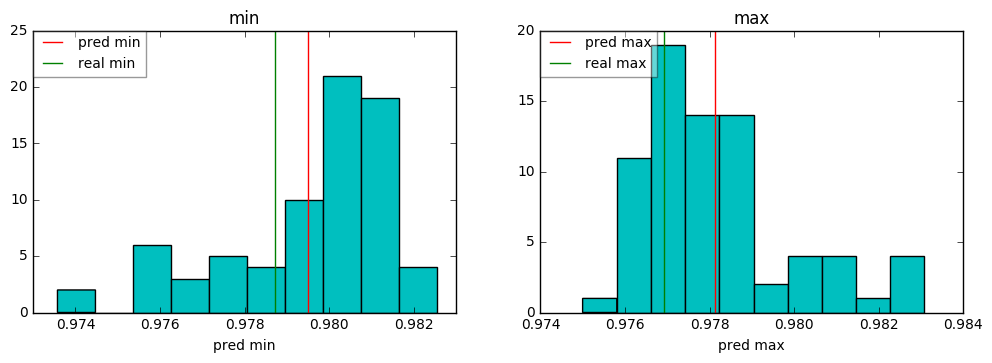

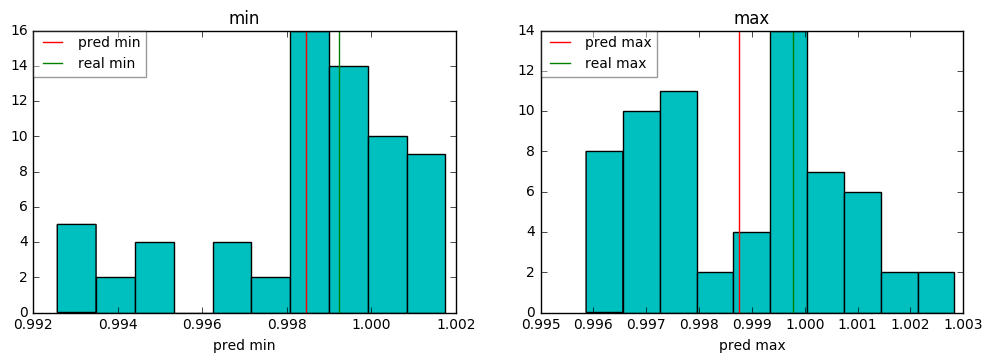

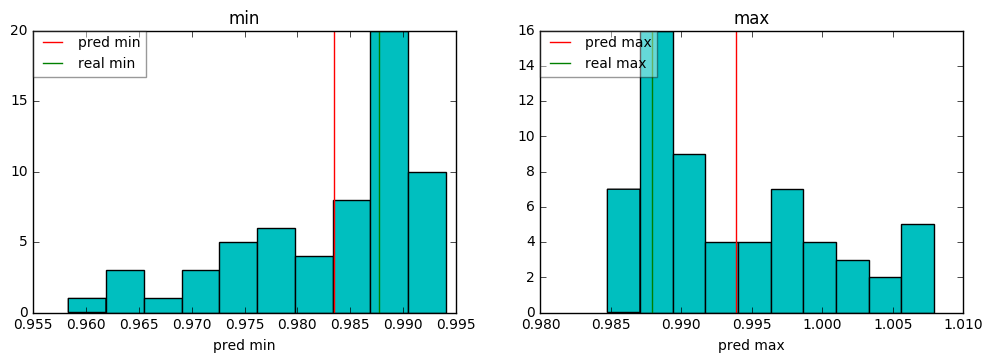

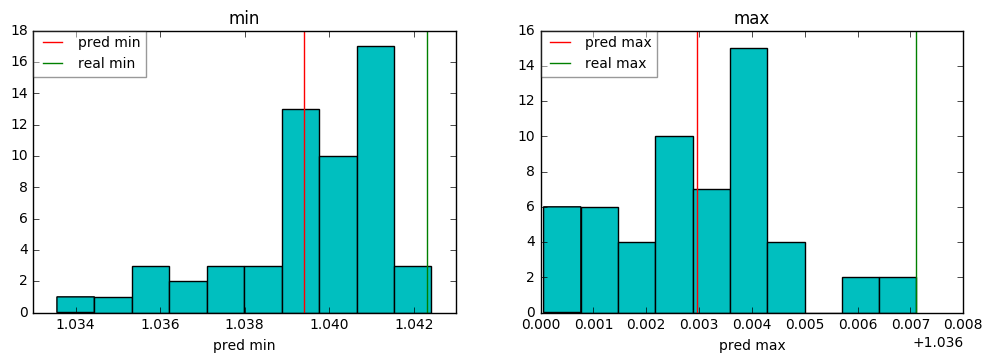

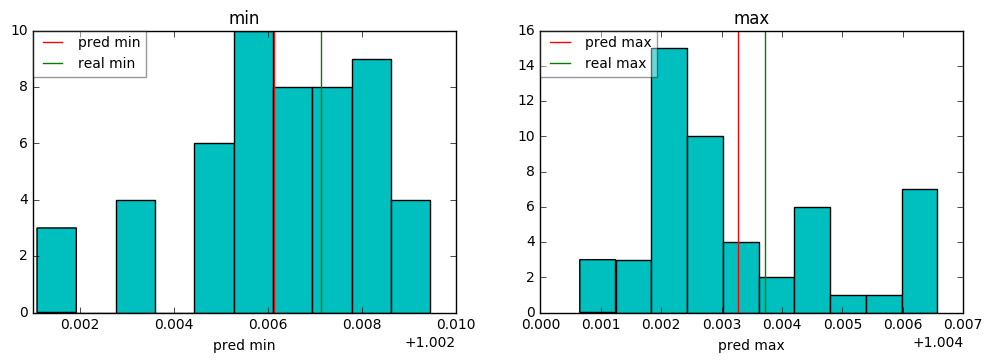

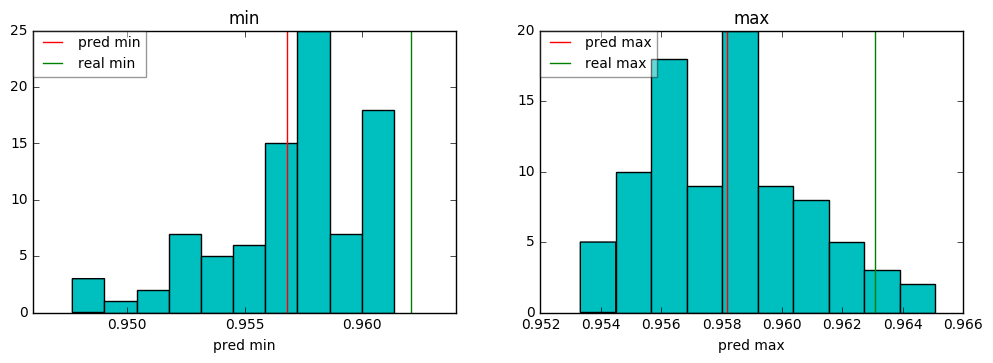

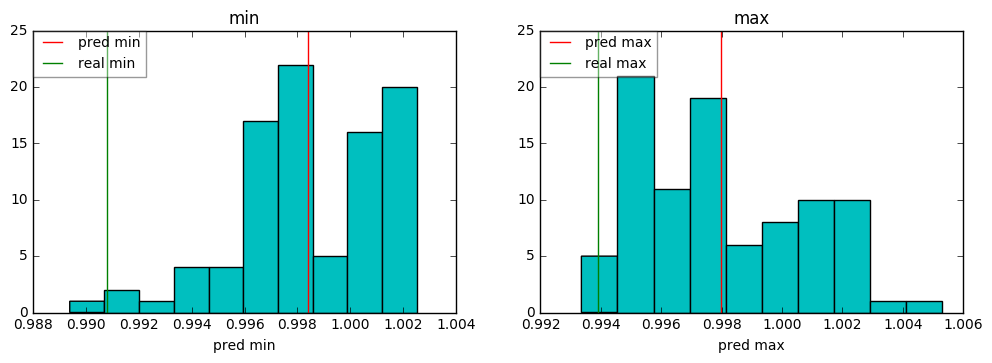

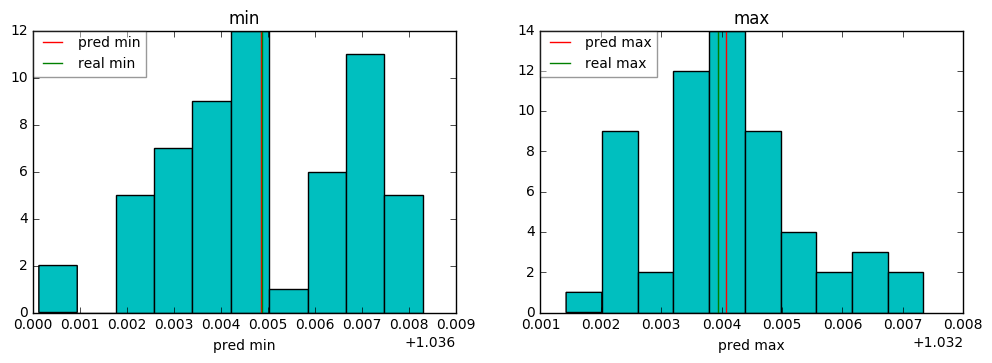

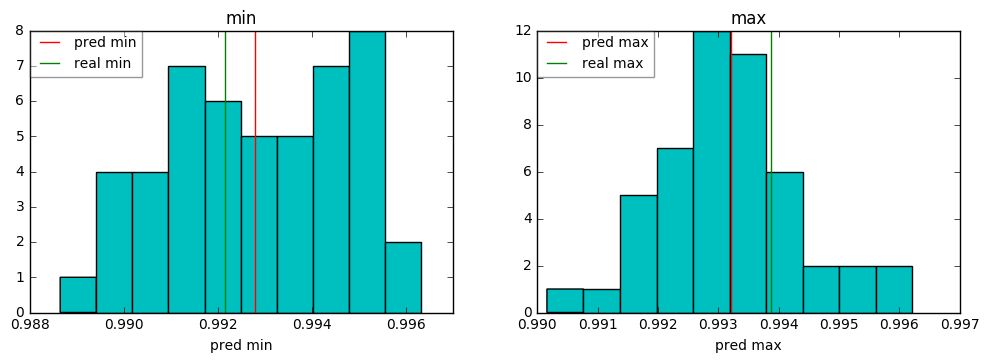

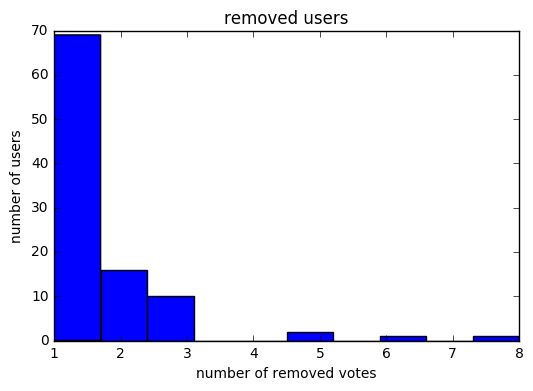

In [154]:
df = pd.DataFrame.from_csv('pricing_answers.csv').sort_values(by='event_finished_at')
df['user_id'] = df.index
new_data = pd.DataFrame(df.keys())
removed = pd.DataFrame(new_data.keys())
df = df[df['ticker_id'] == ticker].groupby('event_id')
last_min = 0
last_max = 0
for group in df:
    if last_min == 0:
        last_min = group[1]['real_min'].mean()
        last_max = group[1]['real_max'].mean()
        continue
    
    Q1 = group[1]['prediction_min'].quantile(0.25)
    Q3 = group[1]['prediction_min'].quantile(0.75)
    IQR = Q3 - Q1
    filtered = group[1].query('(@Q1 - 1.5 * @IQR) <= prediction_min <= (@Q3 + 1.5 * @IQR)')
    removed = removed.append(group[1].query('prediction_min < (@Q1 - 1.5 * @IQR) or prediction_min > (@Q3 + 1.5 * @IQR)'))
    
    Q1 = filtered['prediction_max'].quantile(0.25)
    Q3 = filtered['prediction_max'].quantile(0.75)
    IQR = Q3 - Q1
    filtered = filtered.query('(@Q1 - 1.5 * @IQR) <= prediction_max <= (@Q3 + 1.5 * @IQR)')
    removed = removed.append(filtered.query('prediction_max < (@Q1 - 1.5 * @IQR) or prediction_max > (@Q3 + 1.5 * @IQR)'))

    new_data = new_data.append(filtered, ignore_index=True)
    
    plt.figure(figsize=(12,8))
    plt.subplot(221)
    plt.title('min')
    plt.xlabel('pred min')
    plt.hist(filtered['prediction_min']/last_min, color='c')
    plt.axvline(filtered['prediction_min'].mean()/last_min, color='r', label='pred min')
    plt.axvline(filtered['real_min'].mean()/last_min, color='g', label='real min')
    plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., prop={'size':10}).get_frame().set_alpha(0.4)
    plt.subplot(222)
    plt.title('max')
    plt.xlabel('pred max')
    plt.hist(filtered['prediction_max']/last_max, color='c')
    plt.axvline(filtered['prediction_max'].mean()/last_max, color='r', label='pred max')
    plt.axvline(filtered['real_max'].mean()/last_max, color='g', label='real max')
    plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., prop={'size':10}).get_frame().set_alpha(0.4)
    plt.show()
    last_min = filtered['real_min'].mean()
    last_max = filtered['real_max'].mean()

removed = removed.groupby('user_id')
frequency = []
for i in removed:
    frequency.append(len(i[1]))
plt.figure()
plt.title('removed users')
plt.ylabel('number of users')
plt.xlabel('number of removed votes')
plt.hist(frequency)
plt.show()

new_data.to_csv('filtered_data.csv')

In [5]:
df = pd.DataFrame.from_csv('pricing_answers.csv').sort_values(by='event_finished_at')
df = df[df['ticker_id'] == ticker]

print('OLD')
back_testing(df)
print('NEW')
back_testing(new_data)

OLD
0.00392781287587
0.0037639946207
NEW
0.00351473358005
0.00334763677493


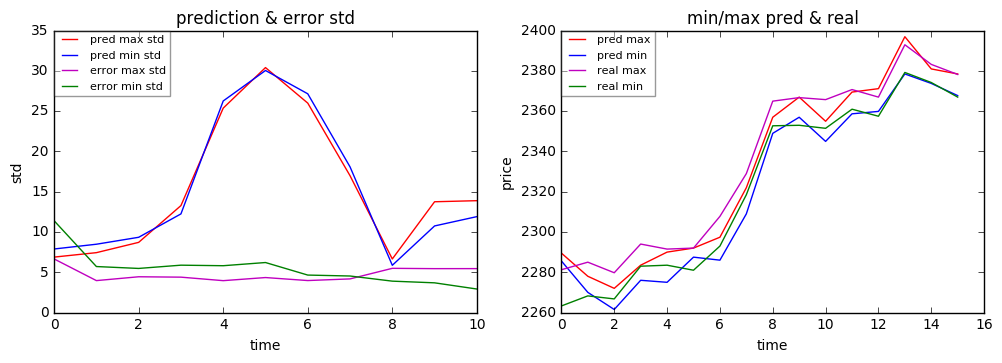

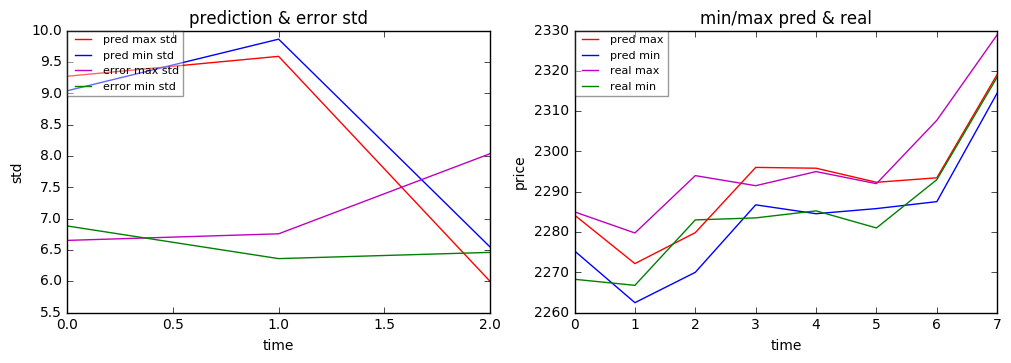

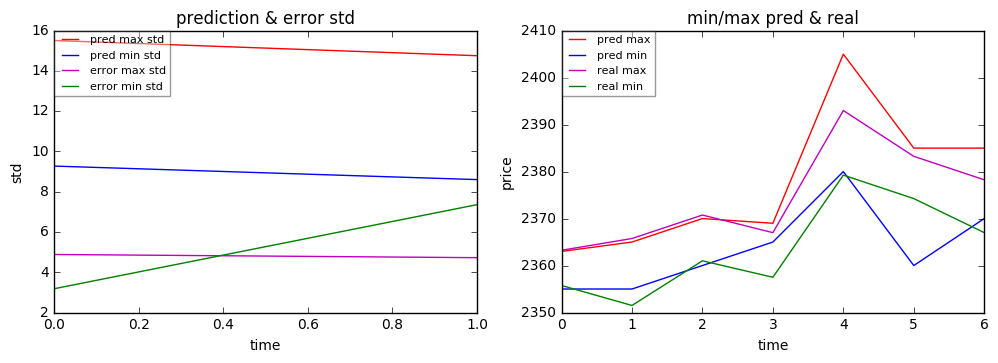

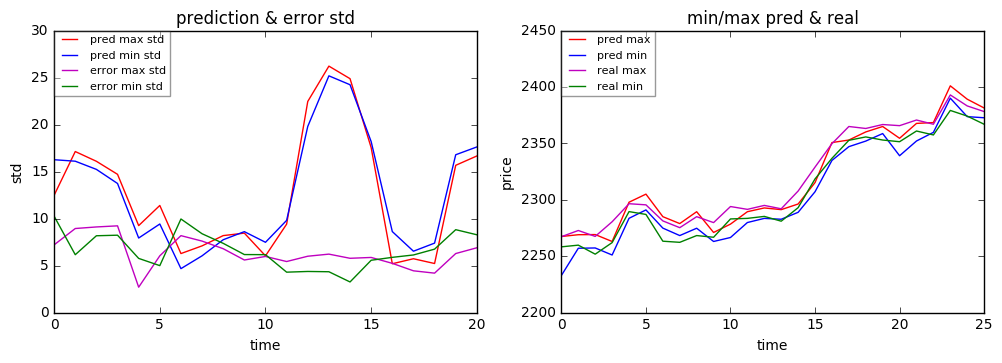

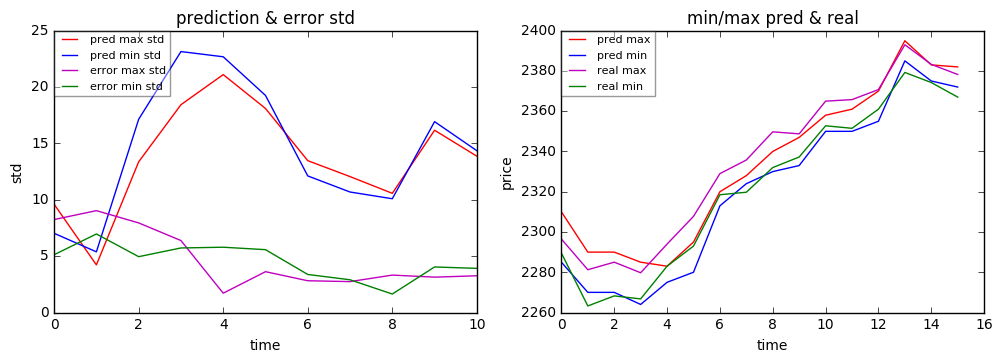

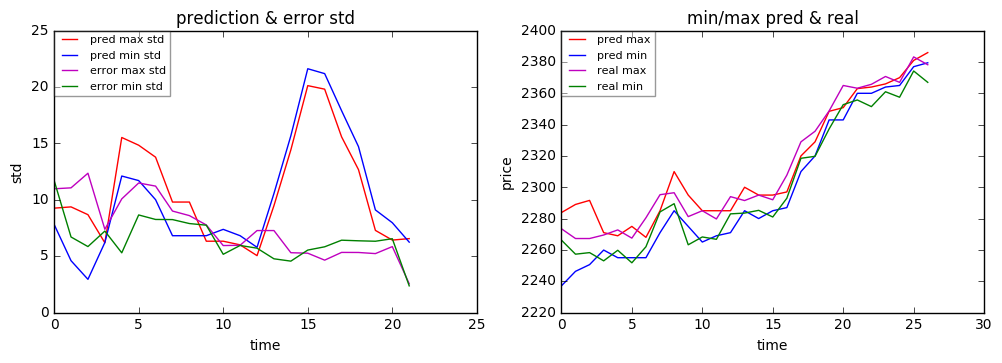

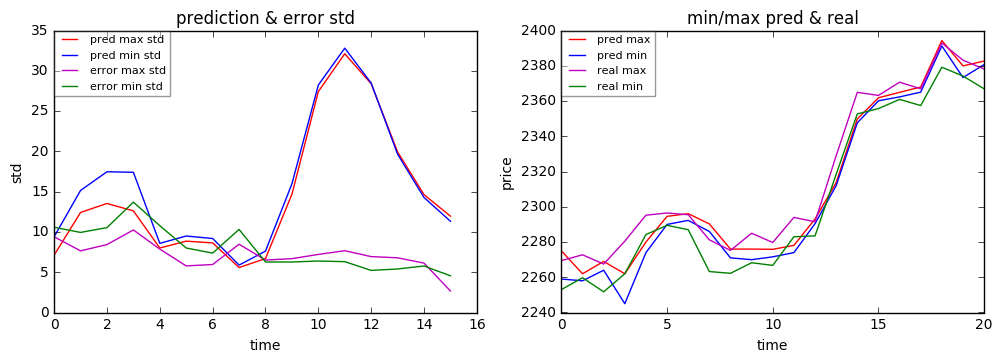

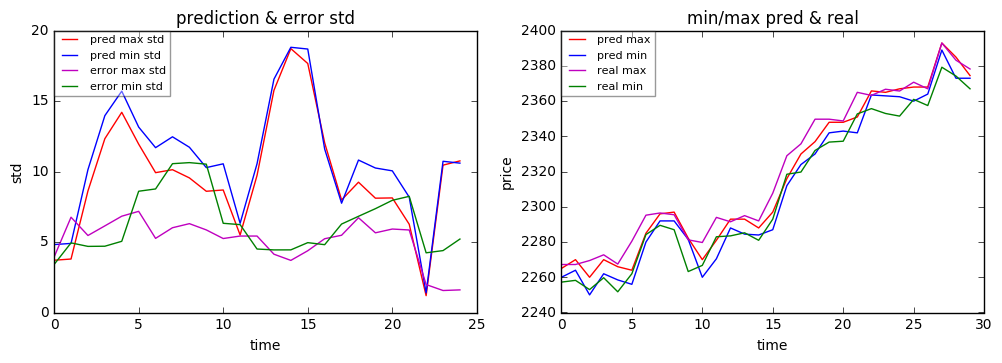

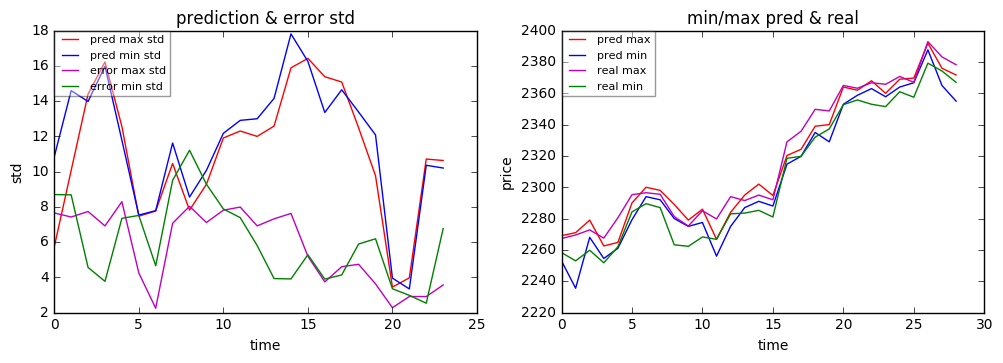

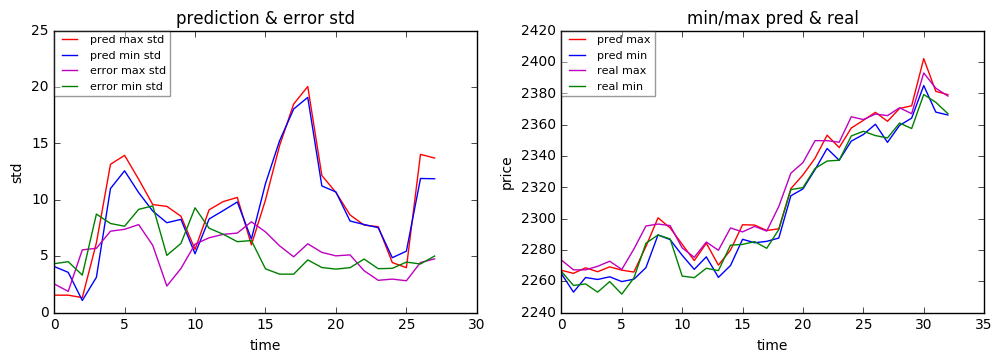

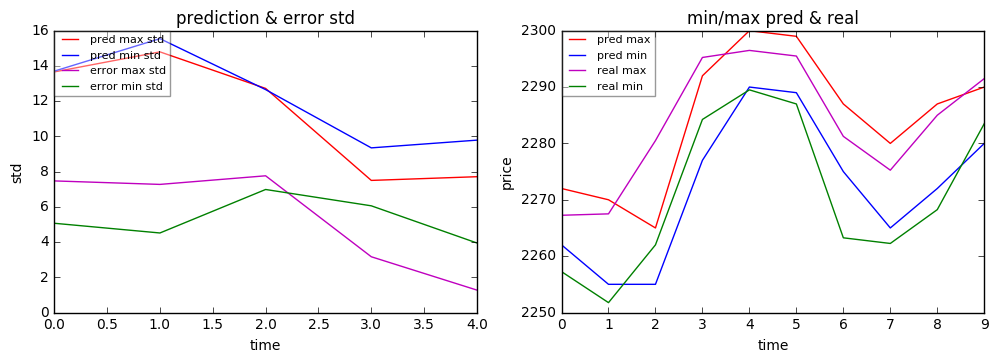

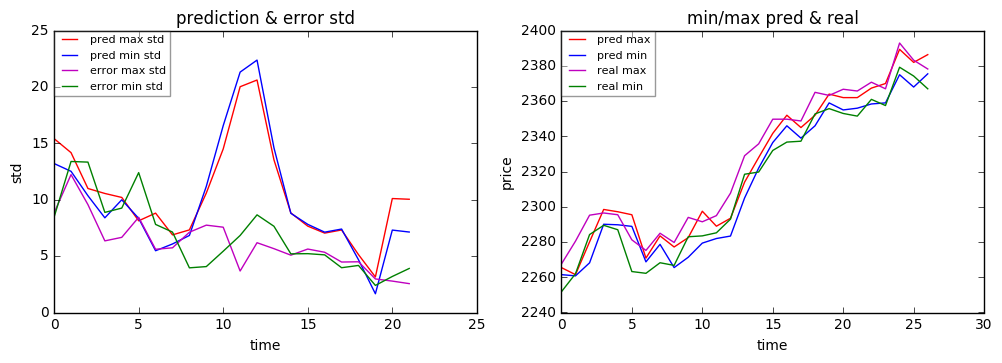

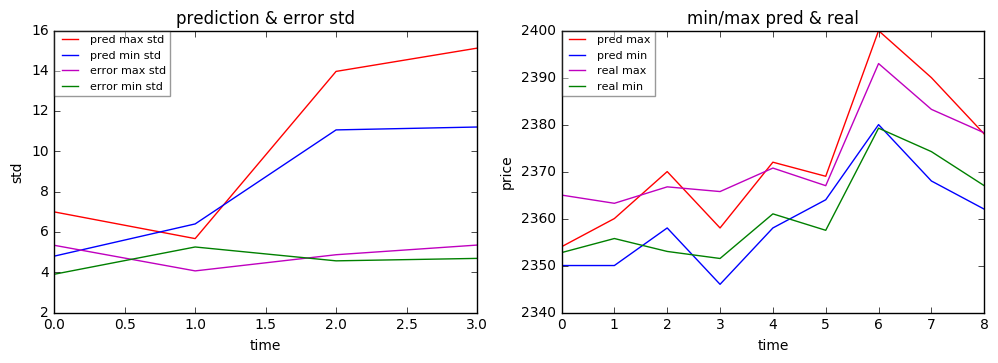

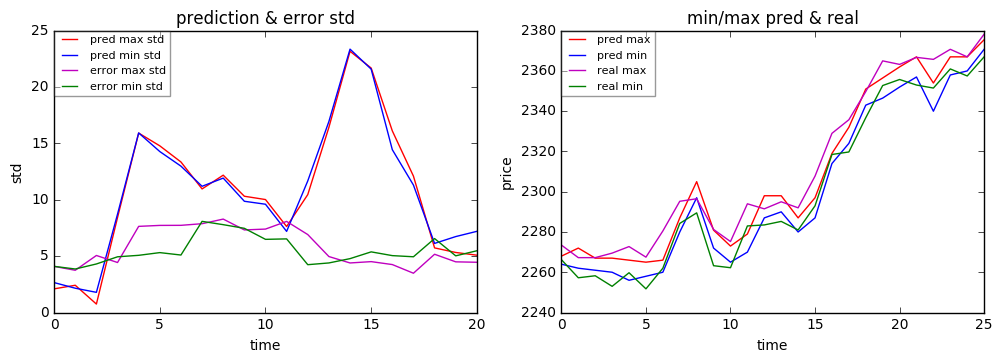

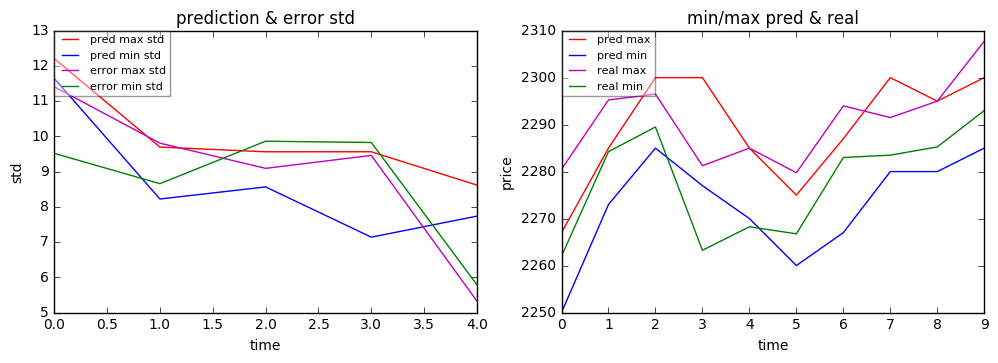

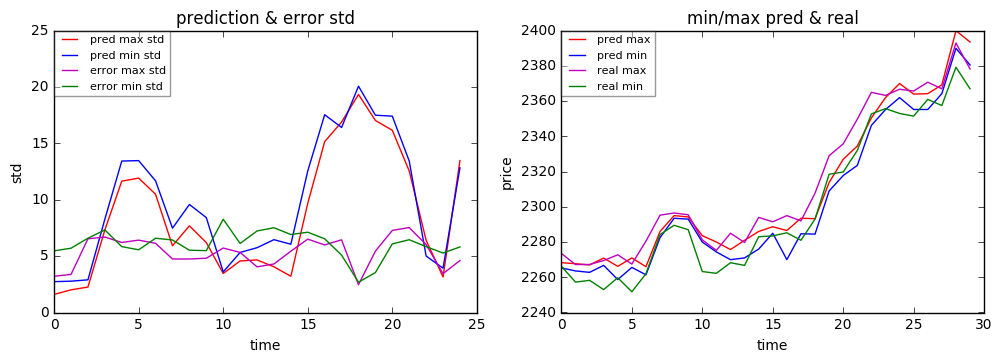

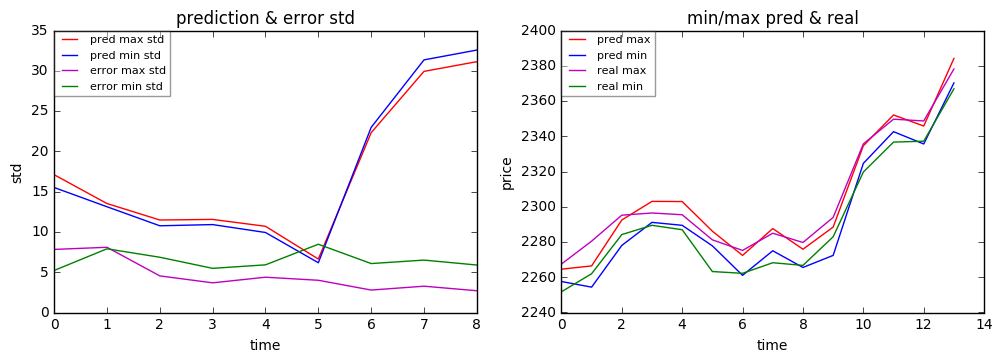

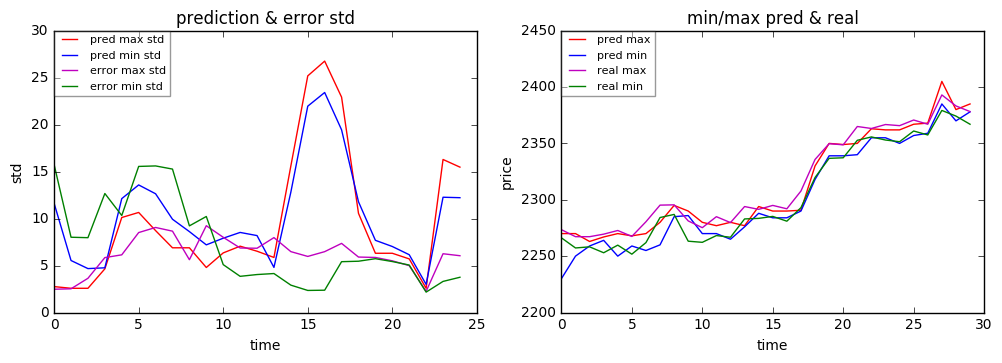

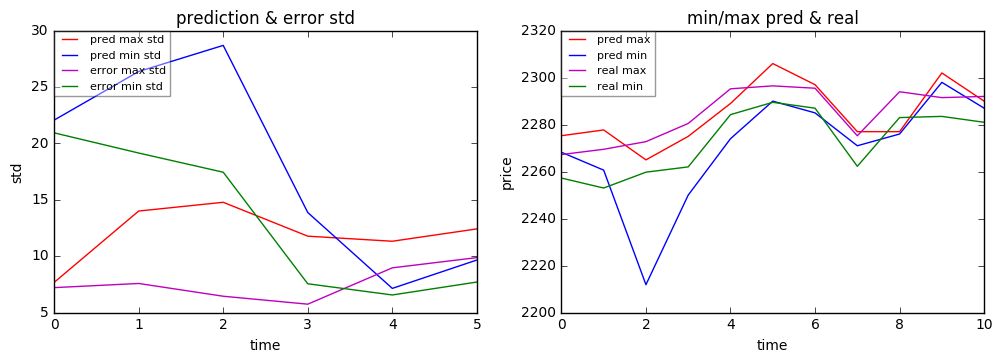

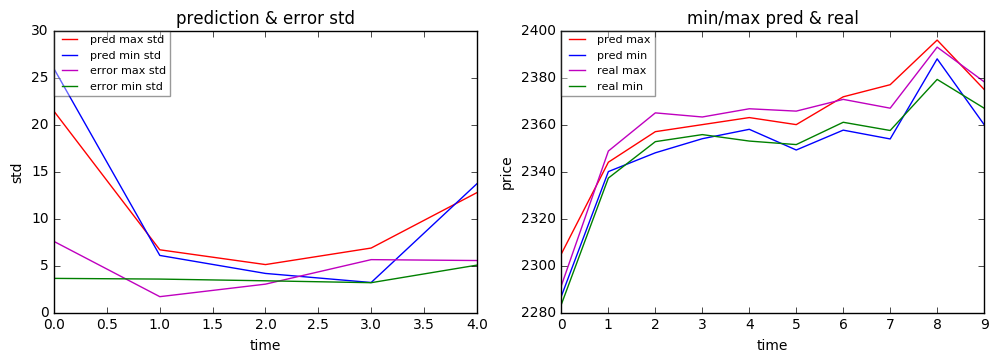

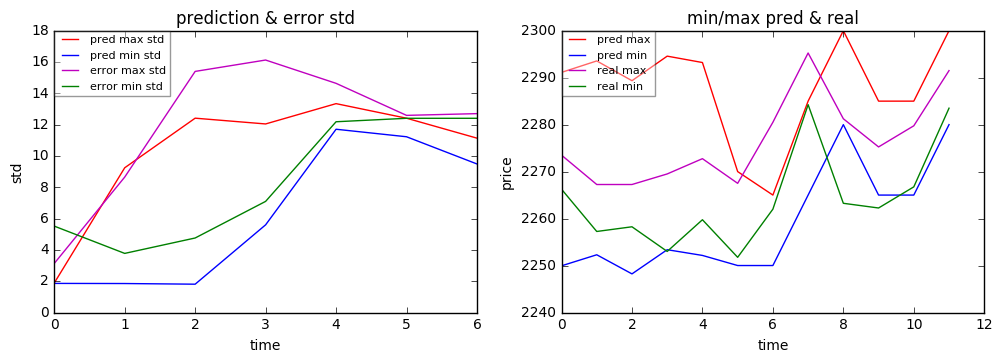

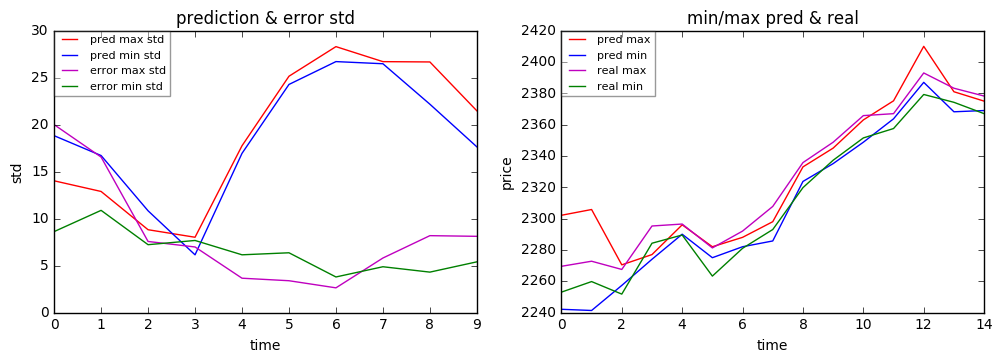

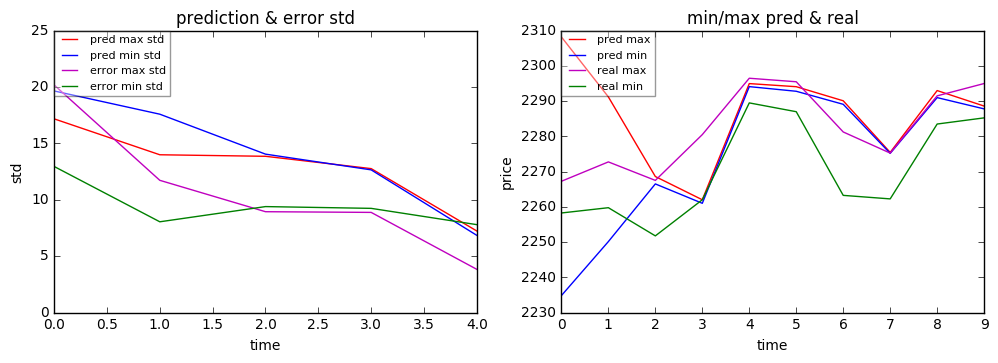

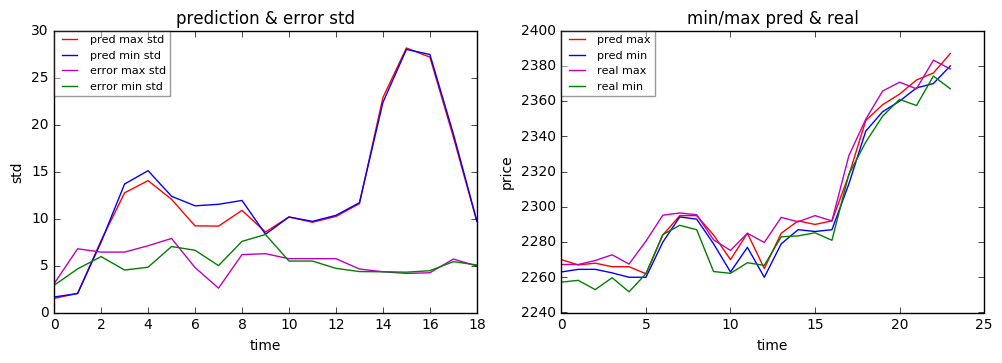

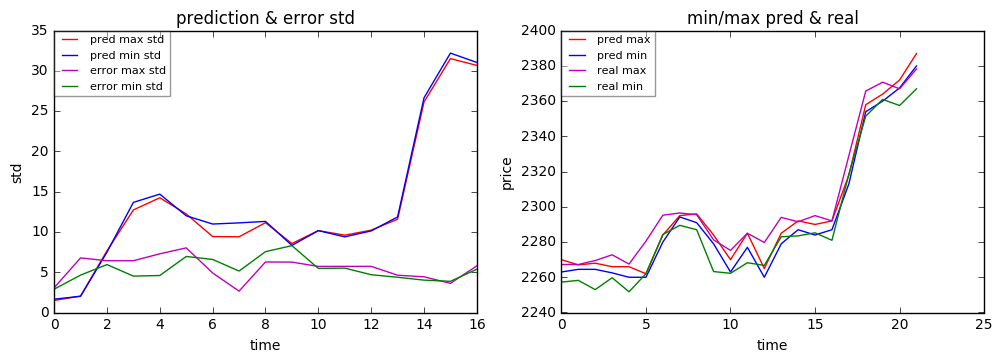

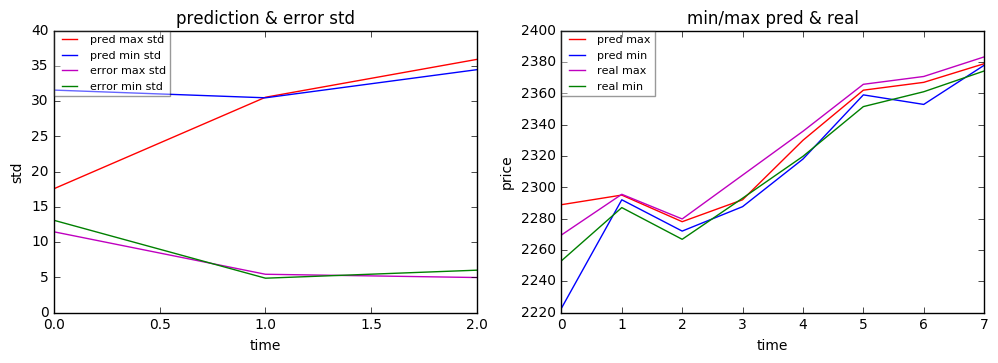

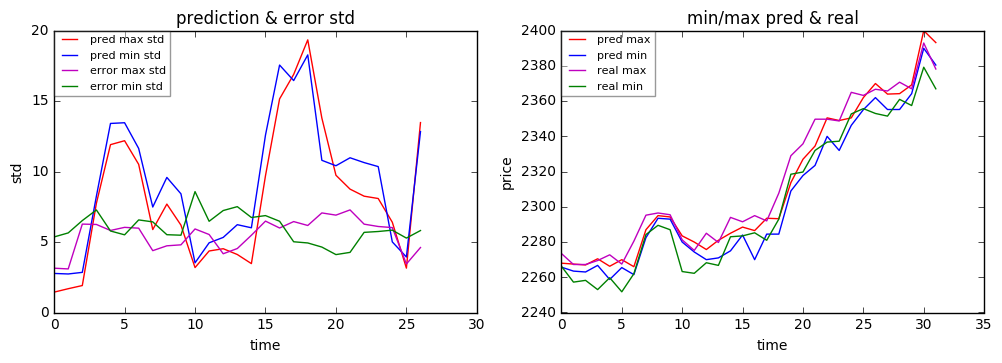

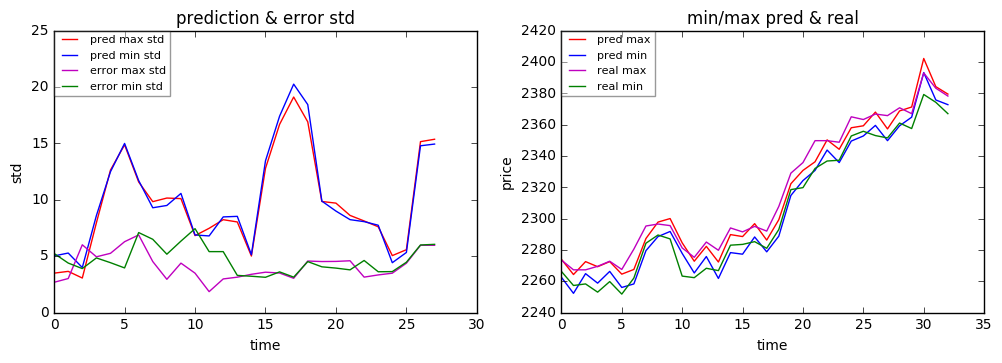

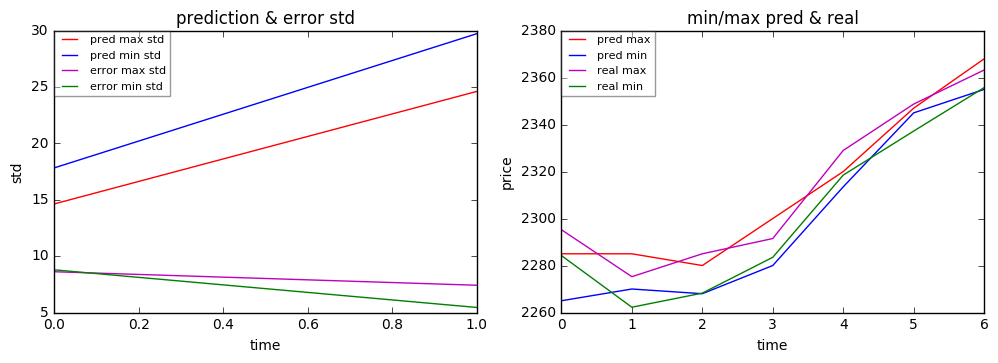

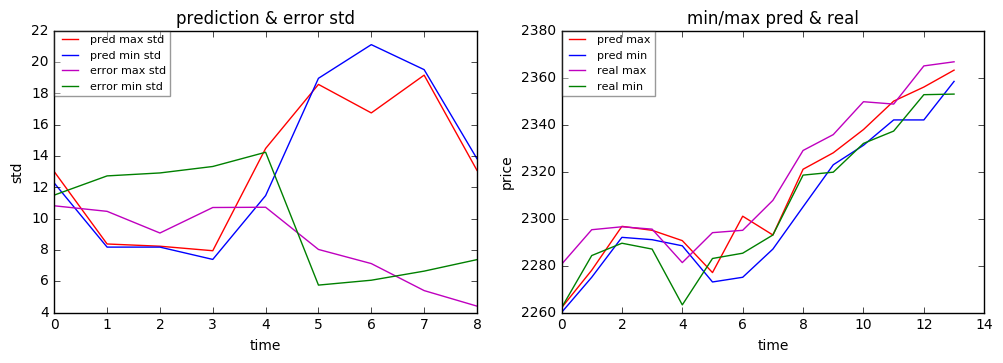

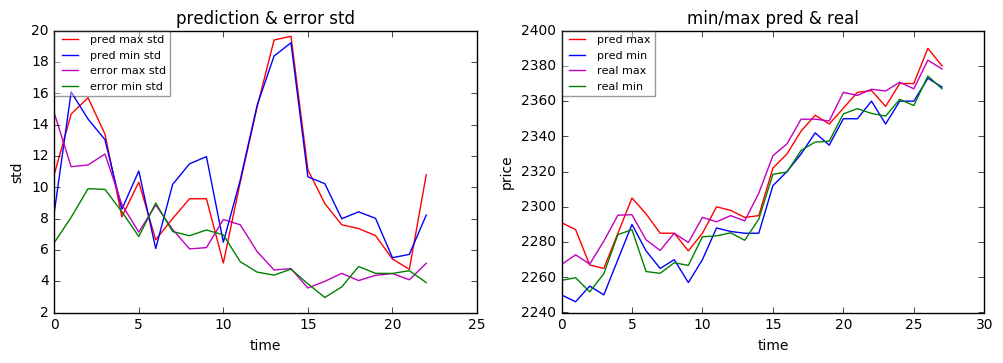

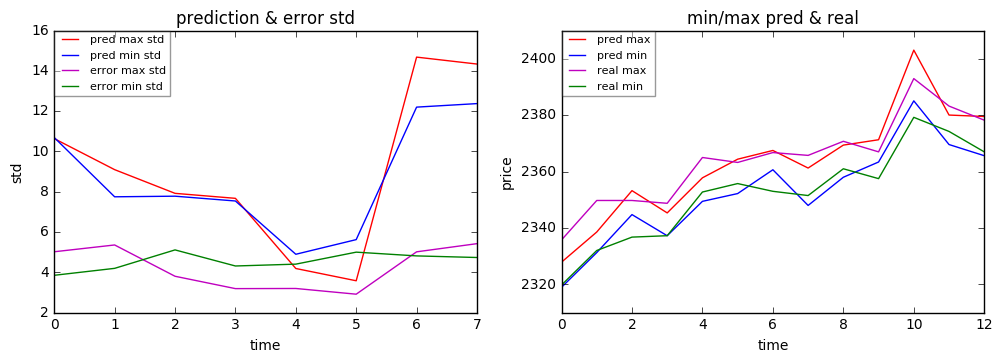

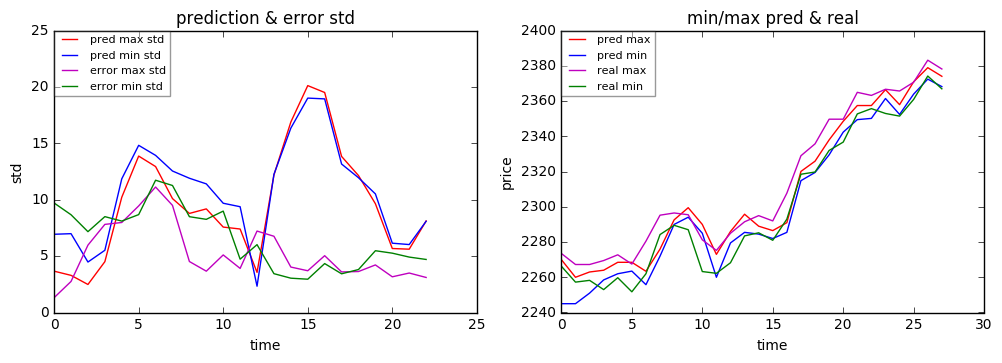

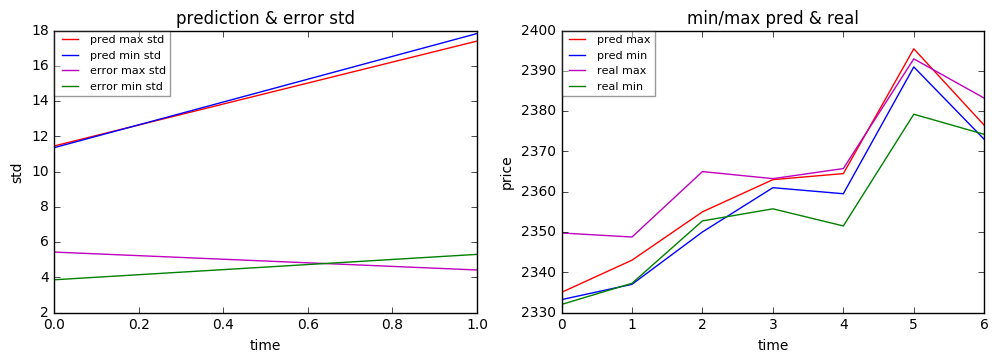

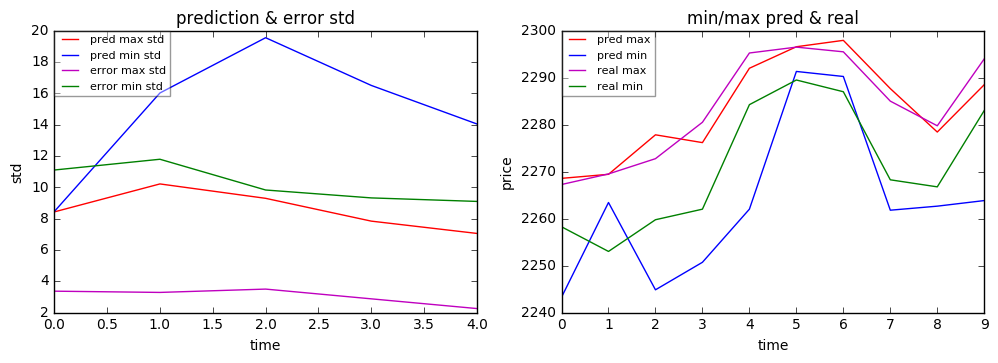

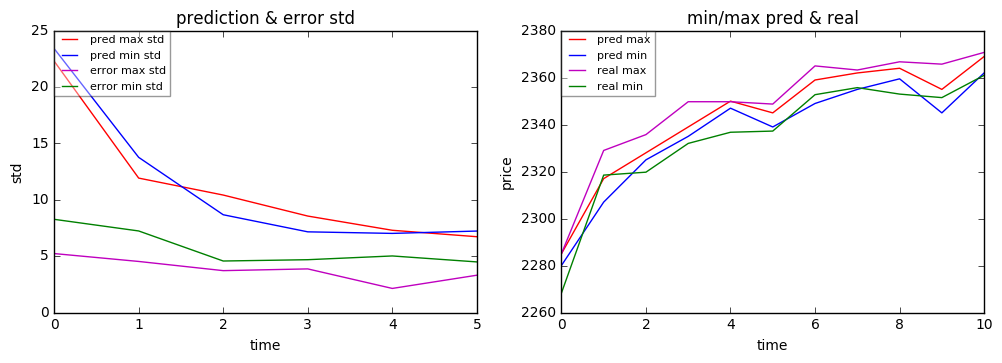

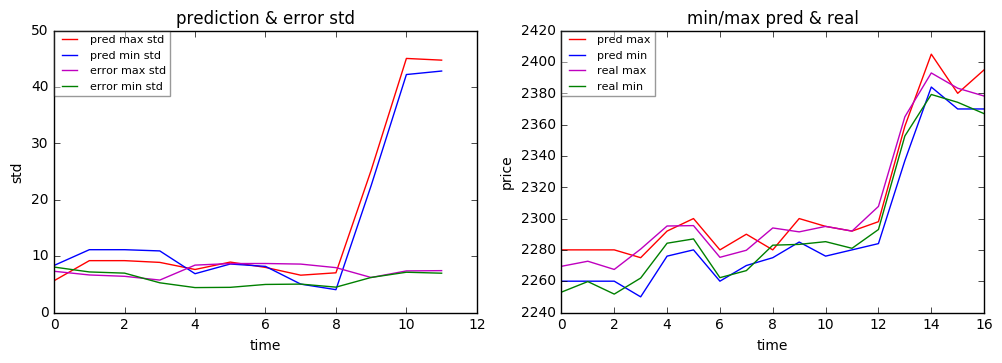

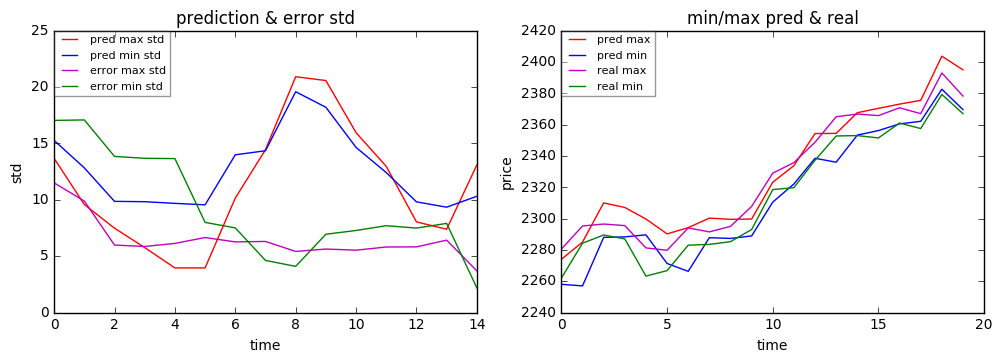

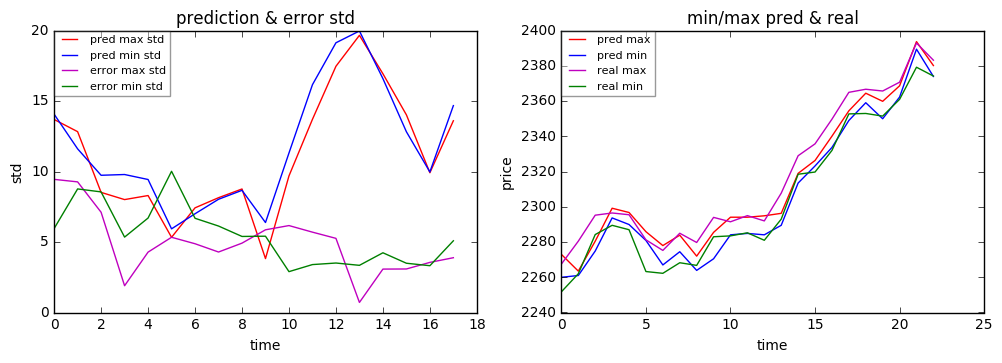

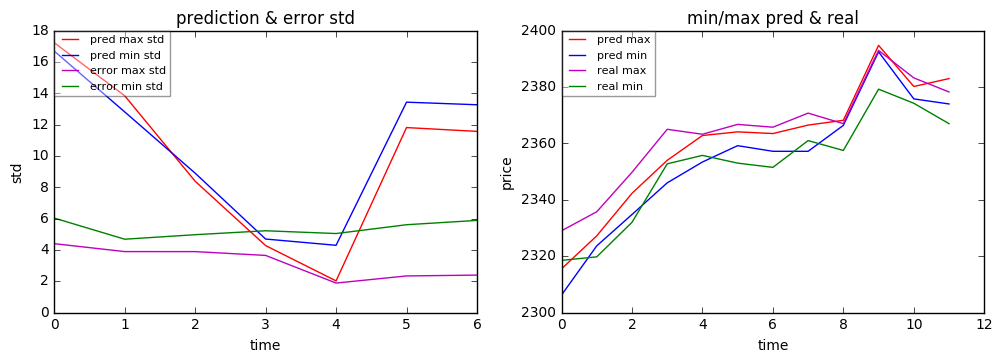

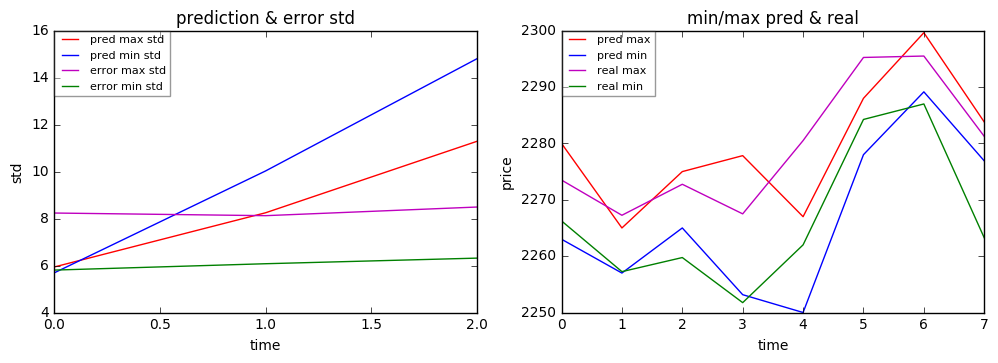

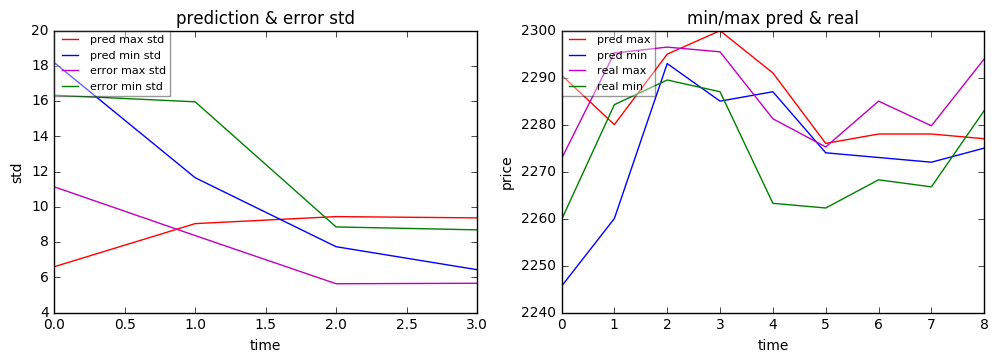

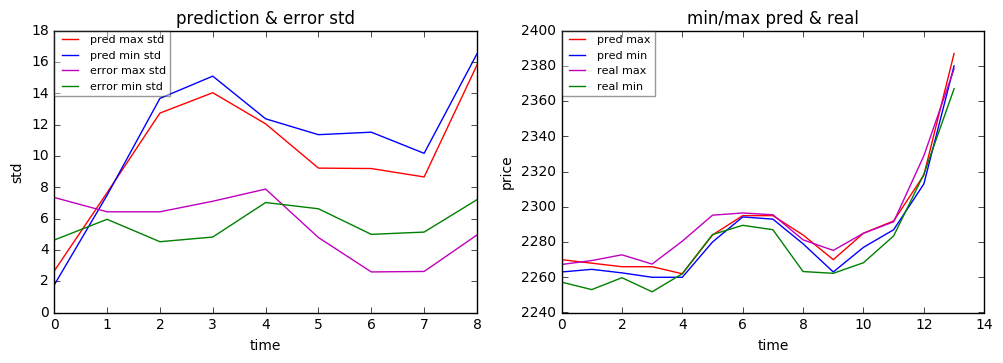

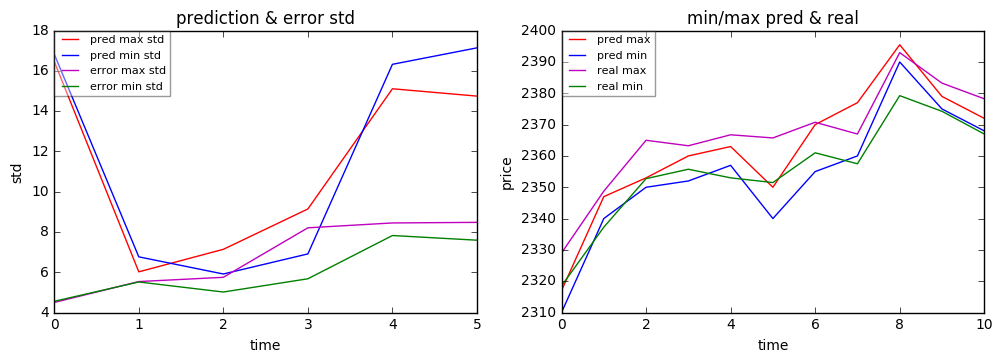

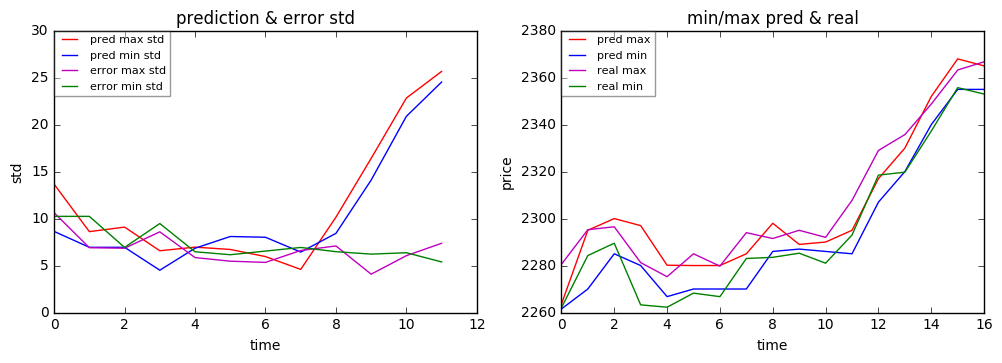

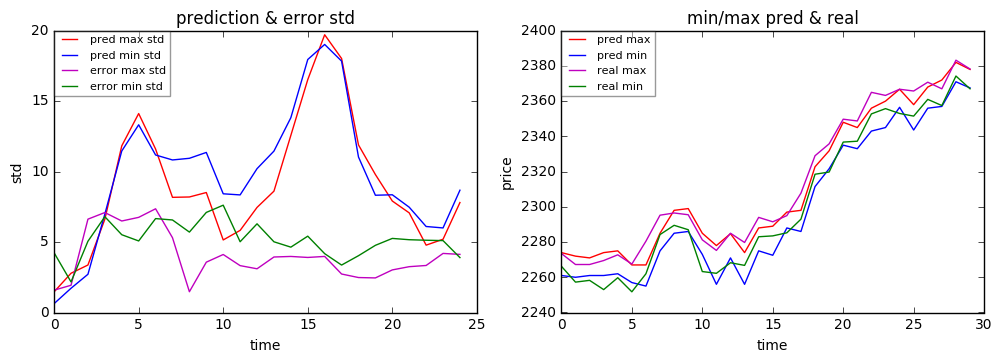

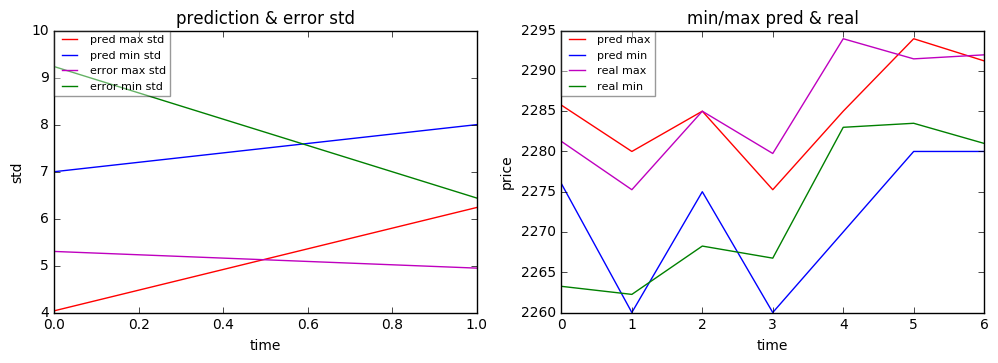

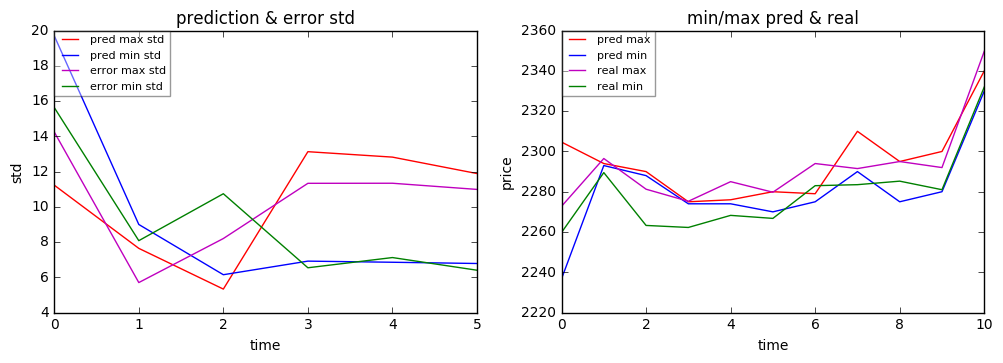

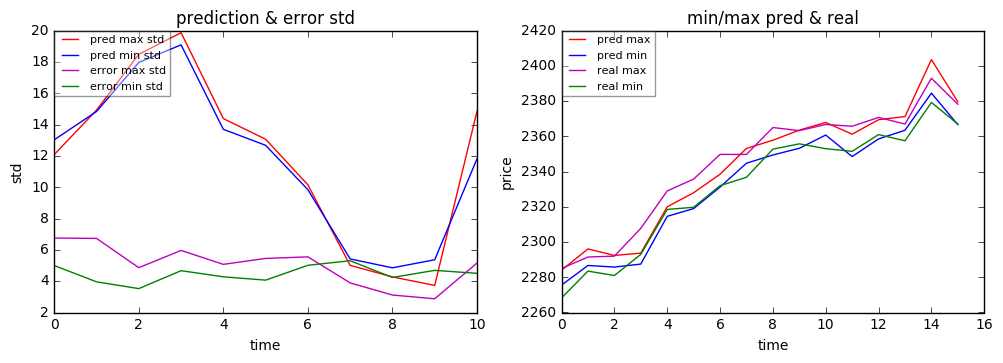

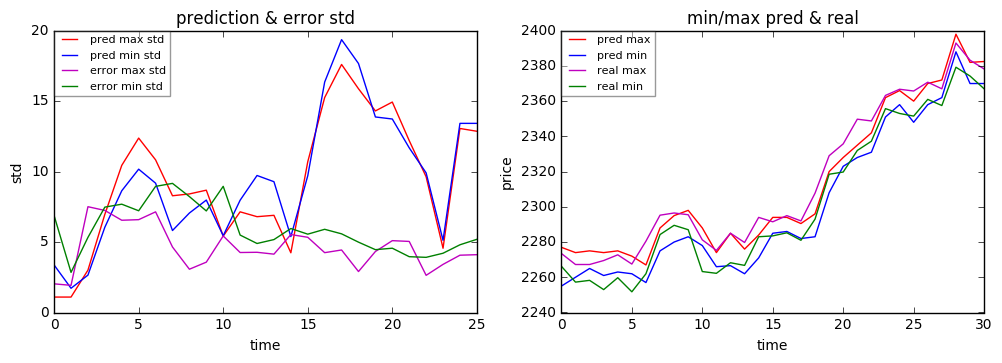

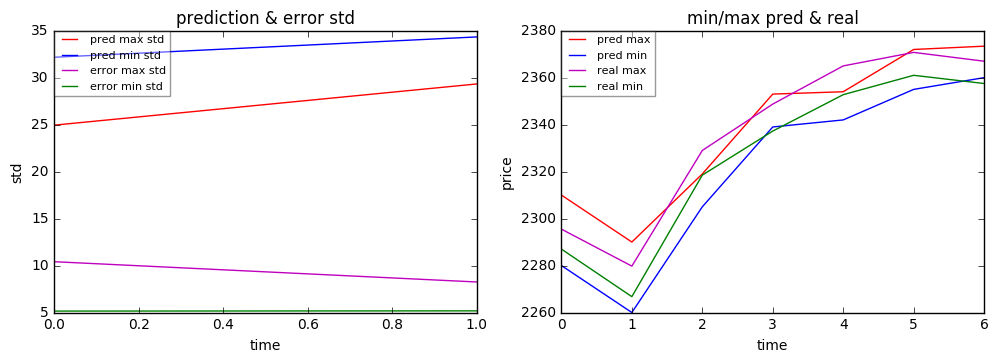

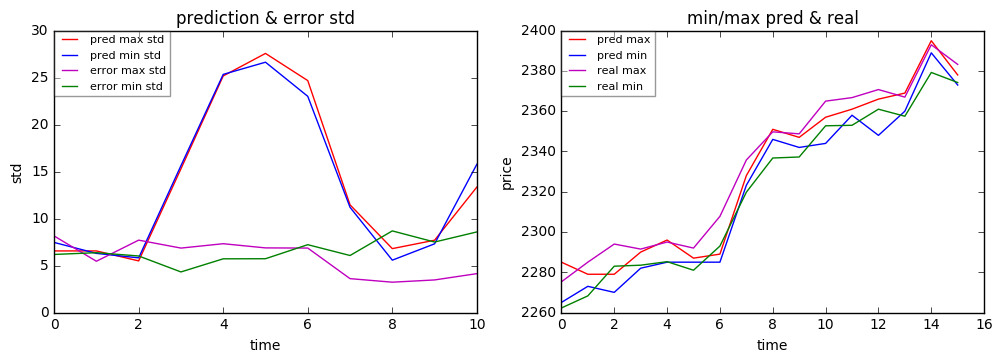

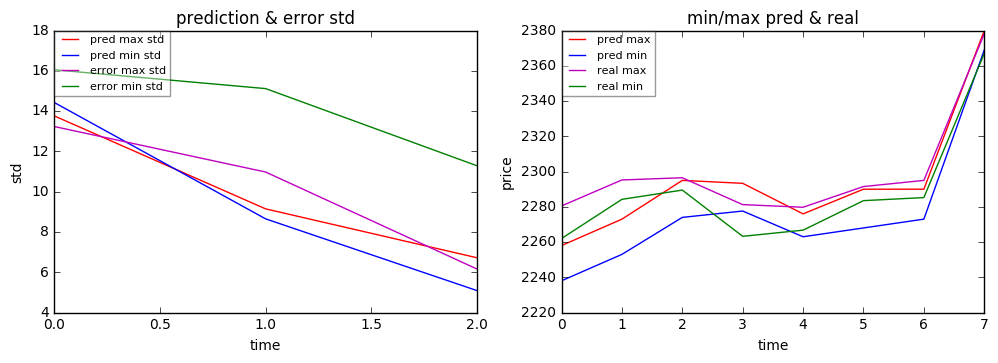

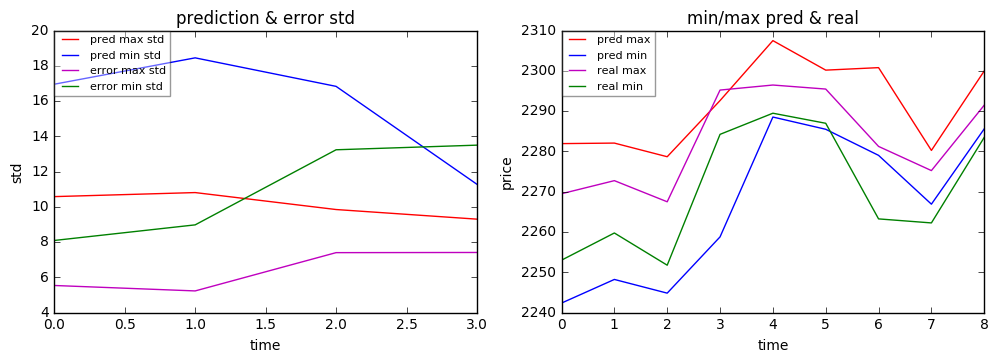

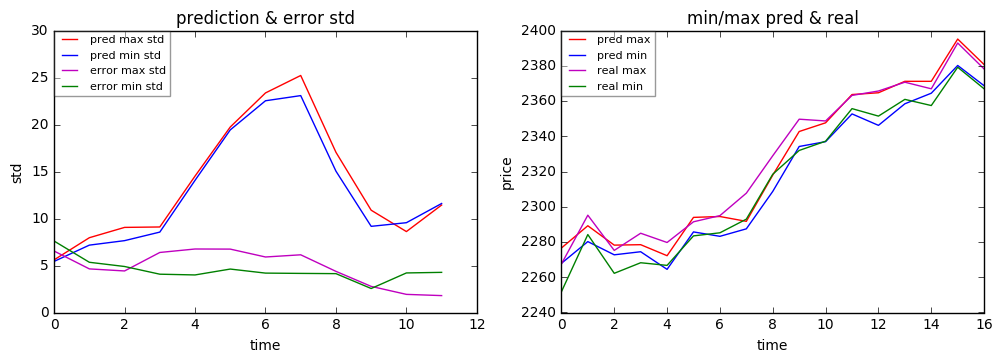

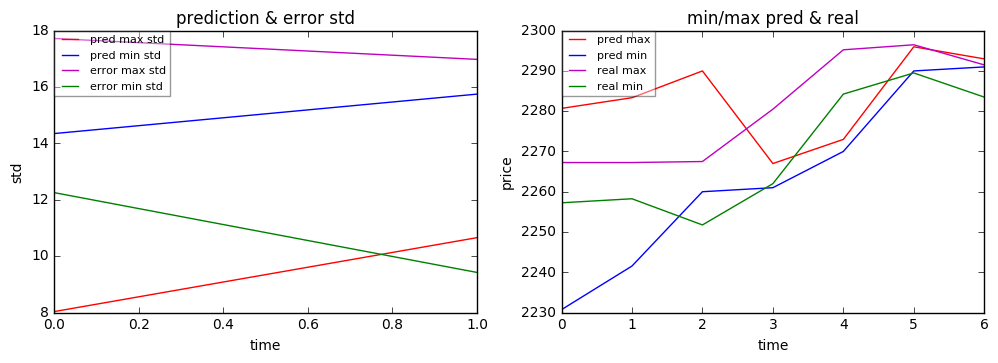

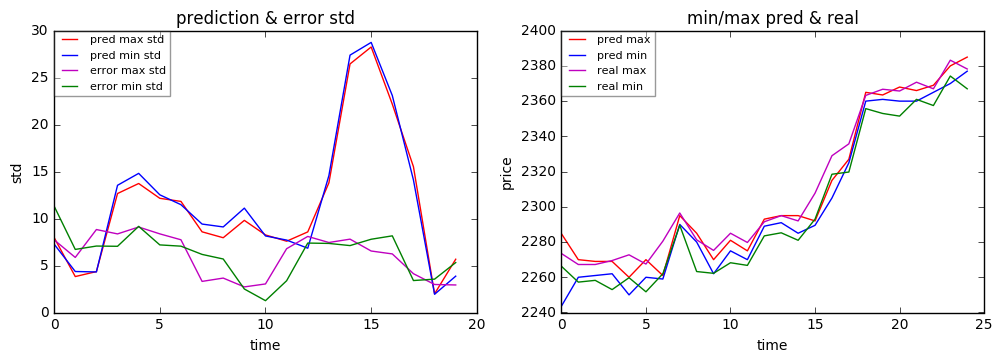

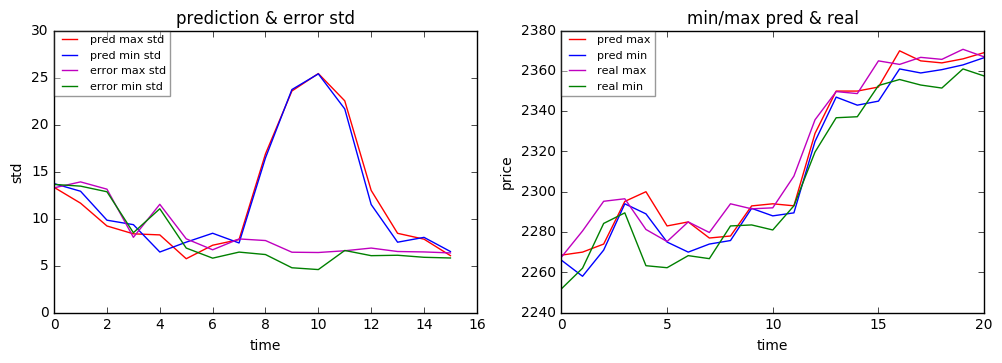

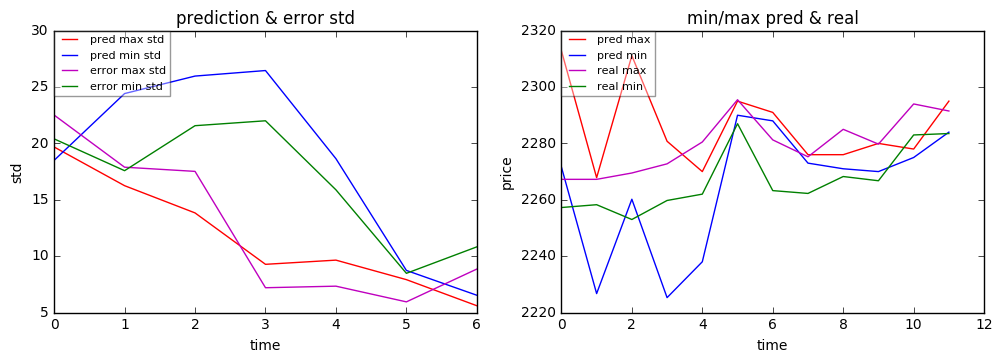

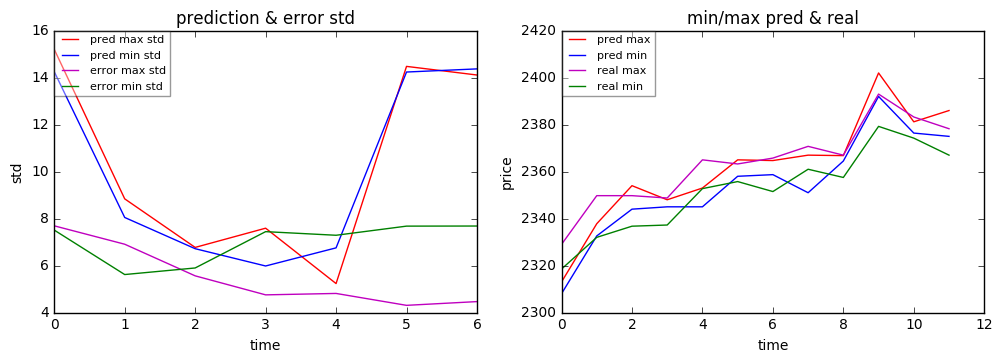

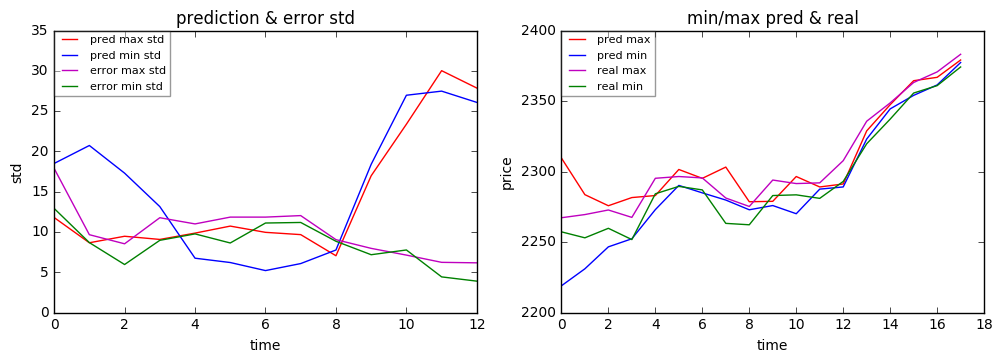

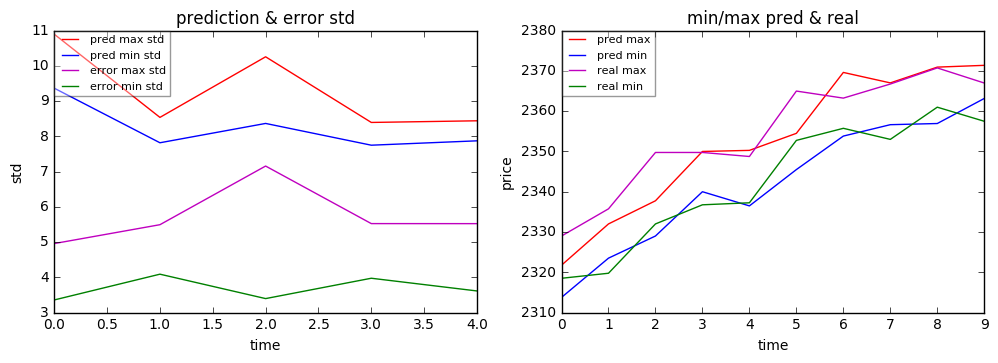

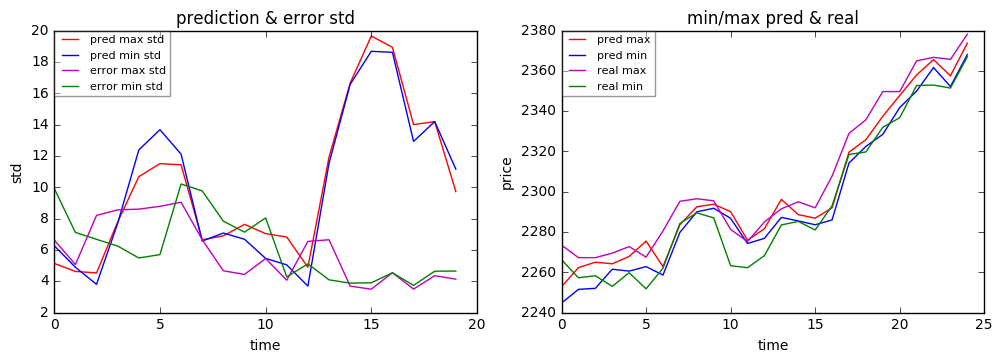

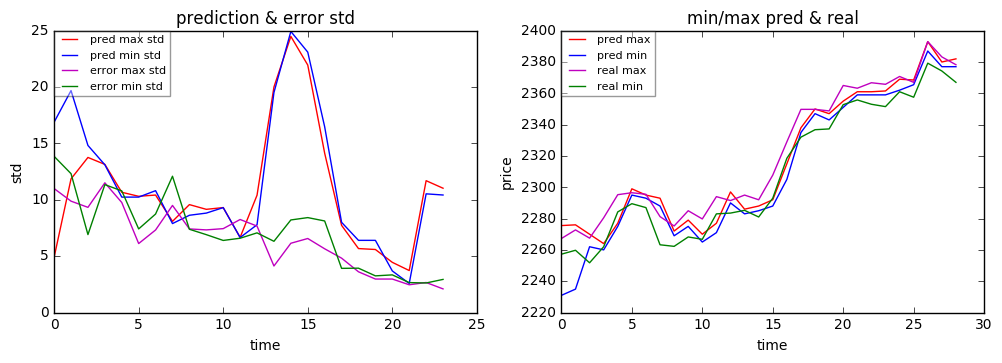

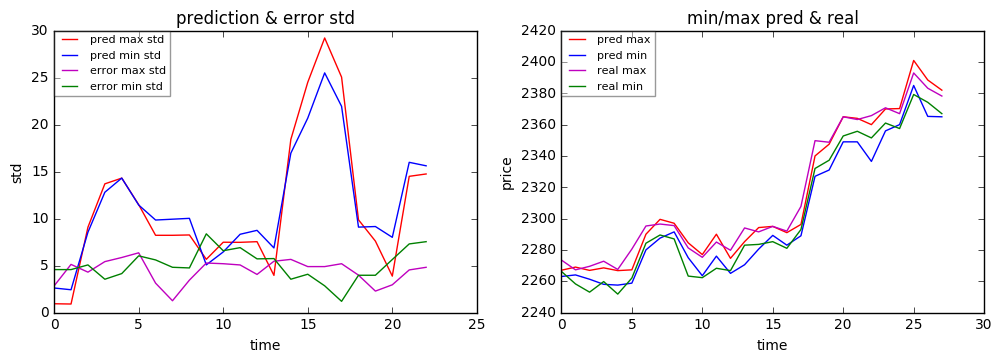

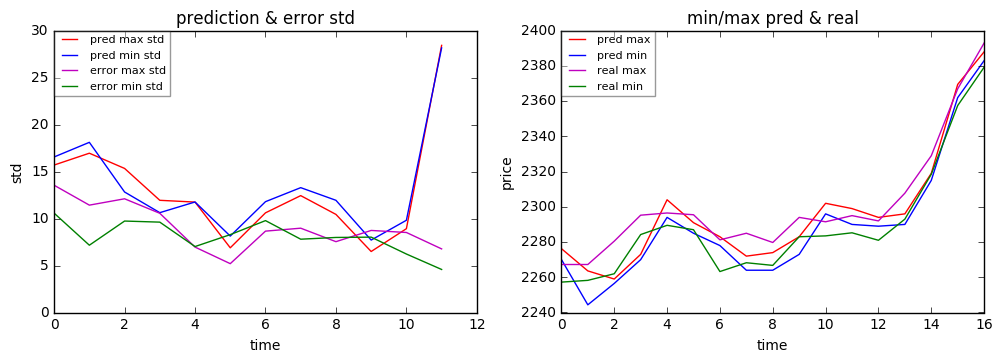

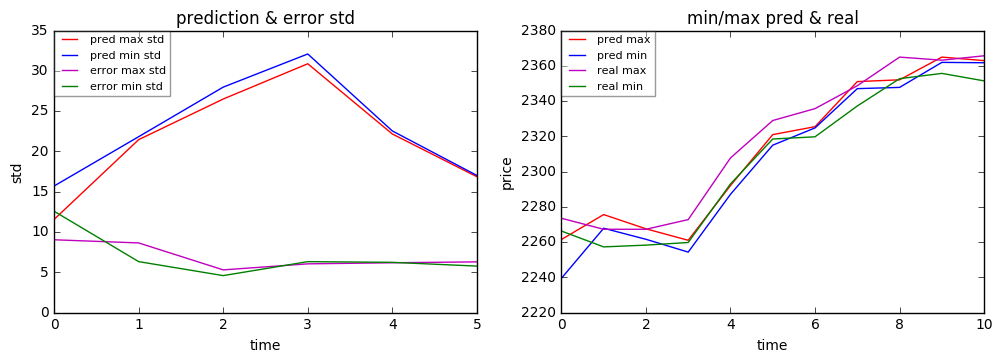

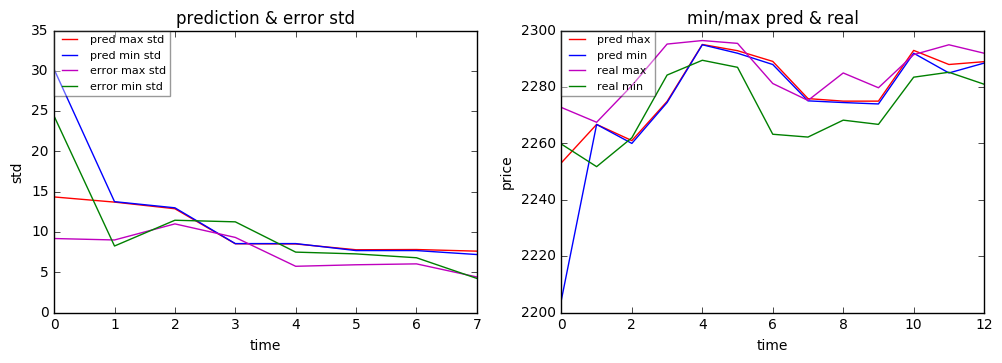

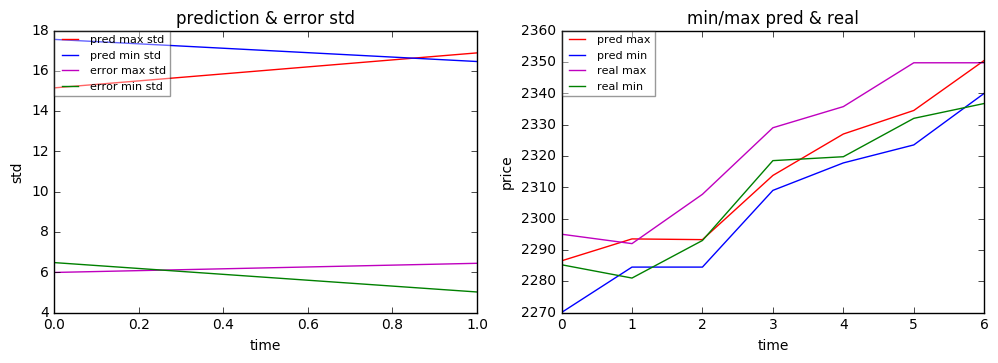

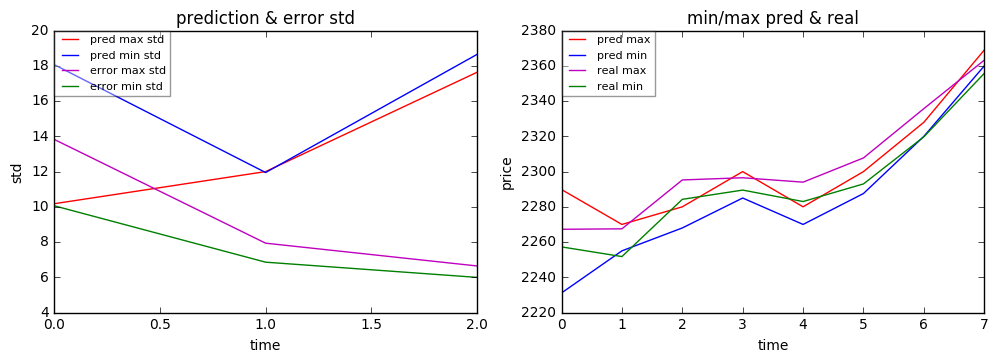

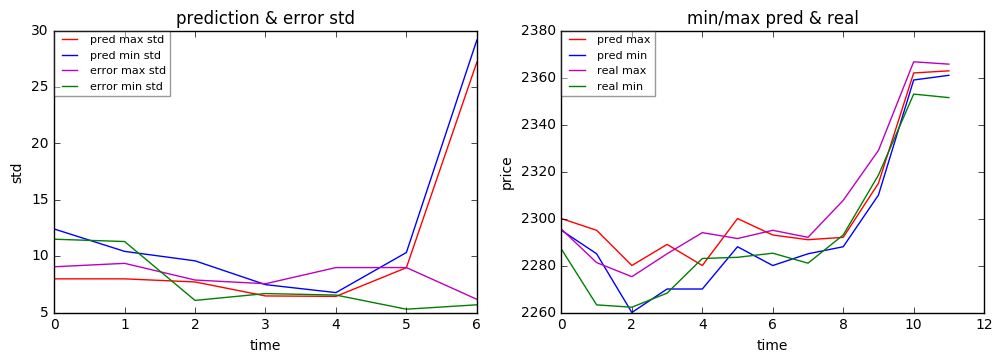

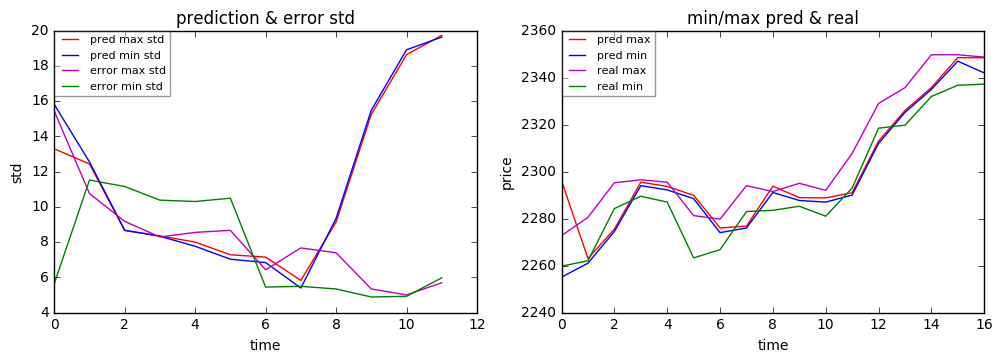

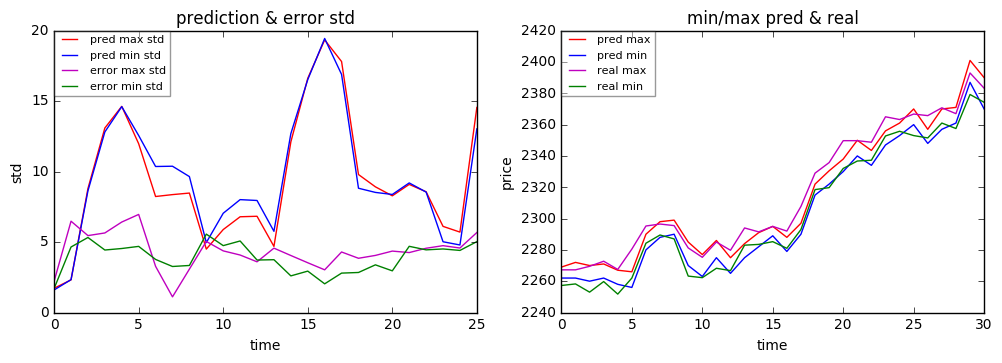

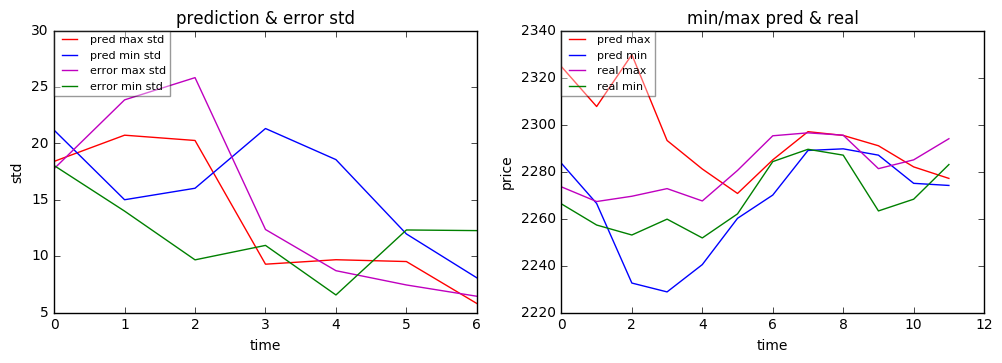

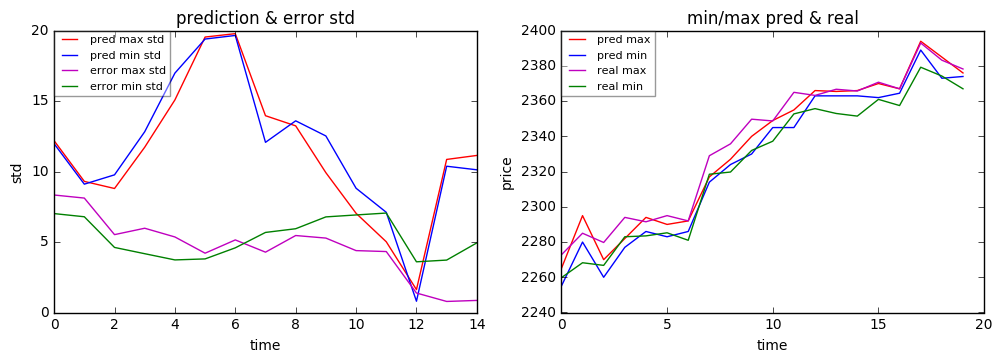

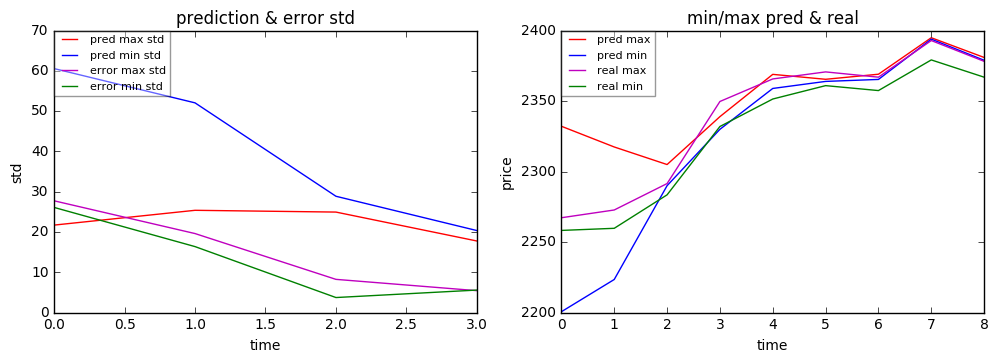

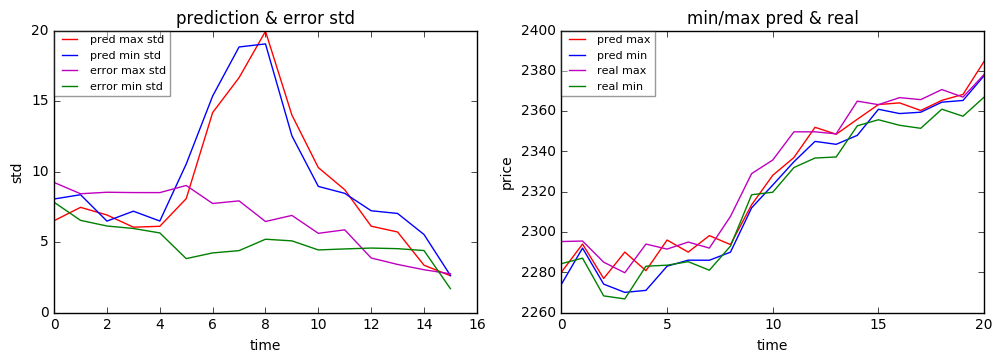

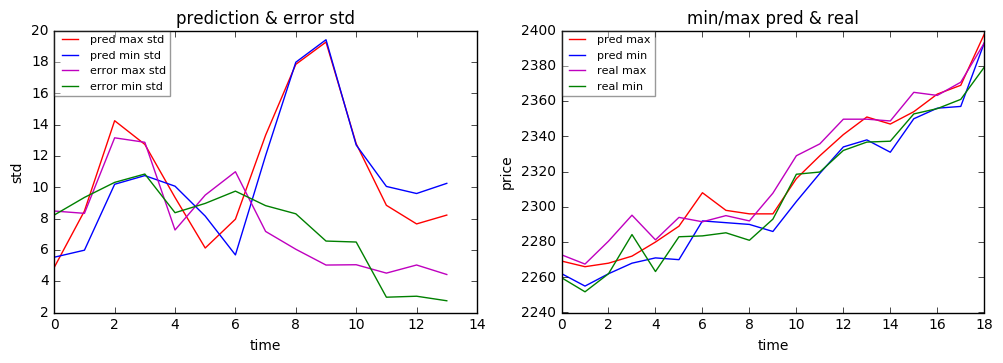

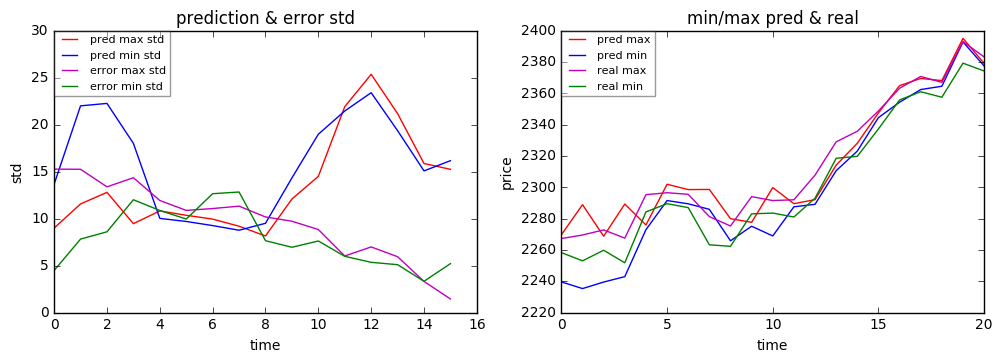

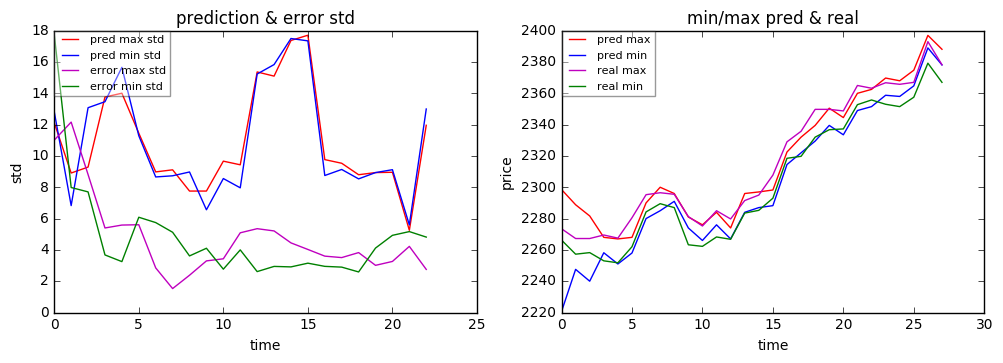

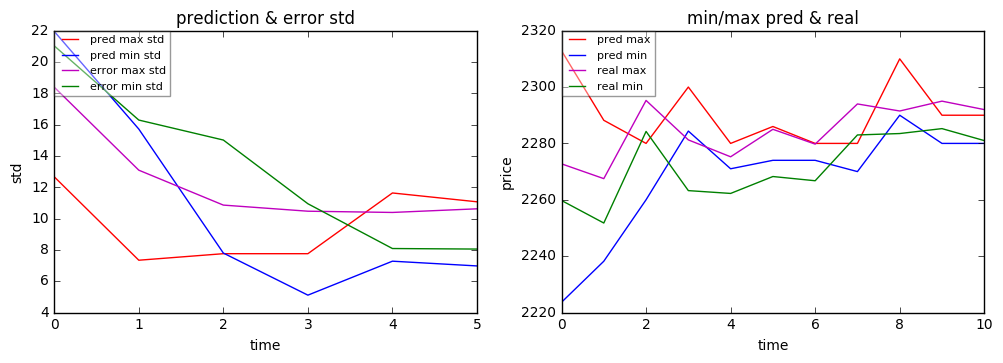

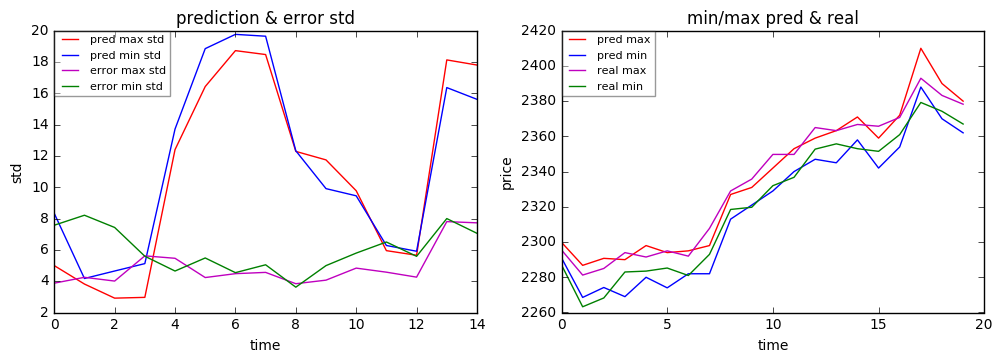

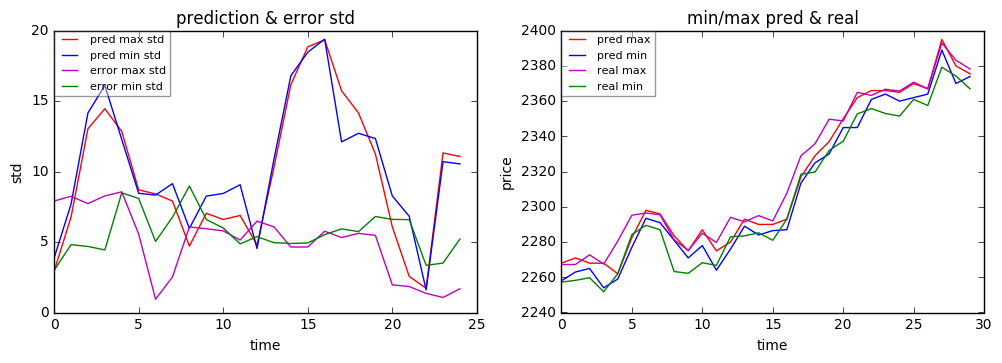

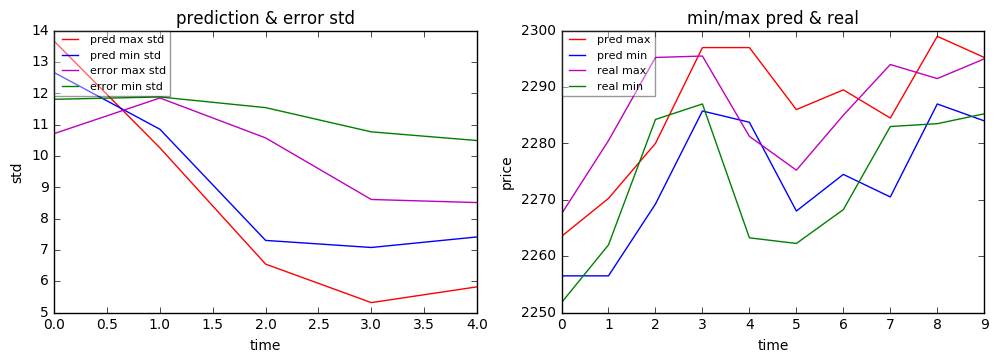

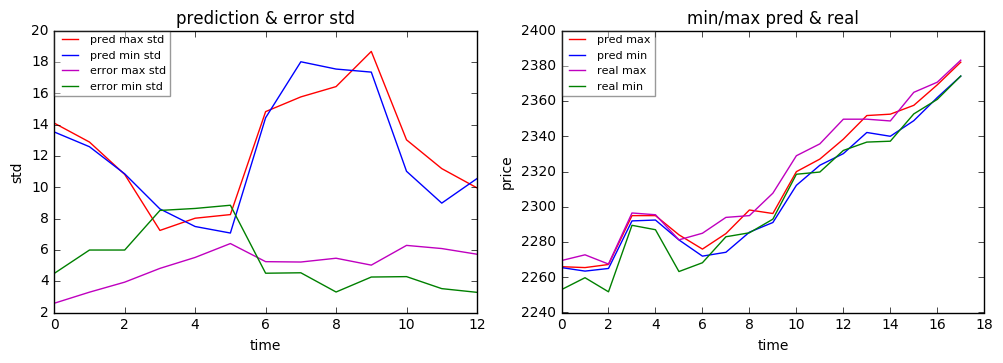

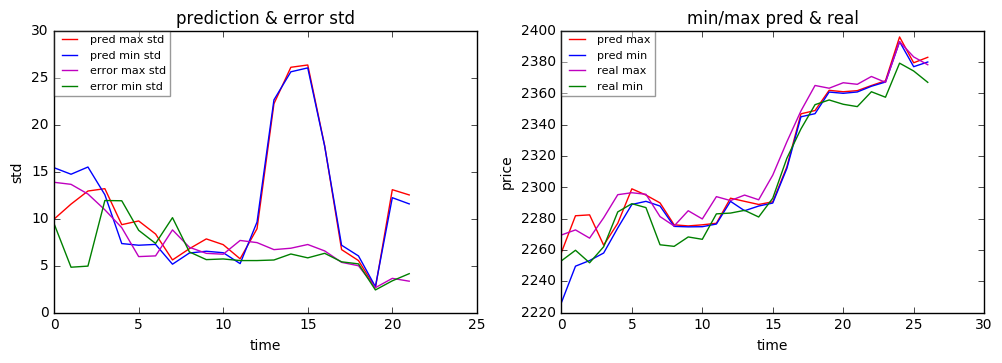

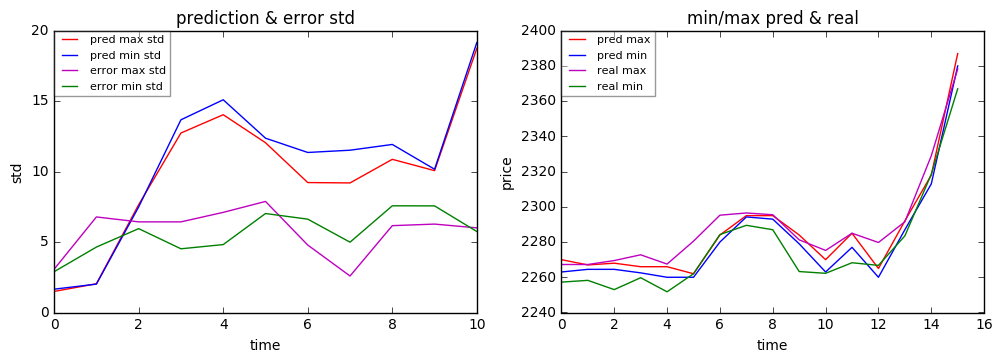

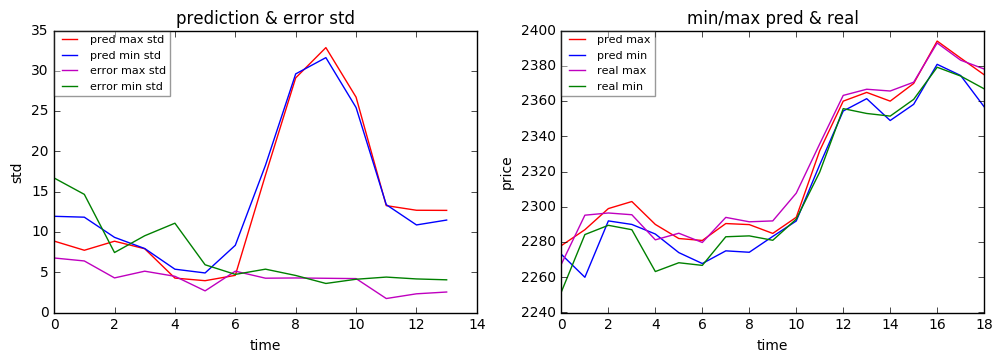

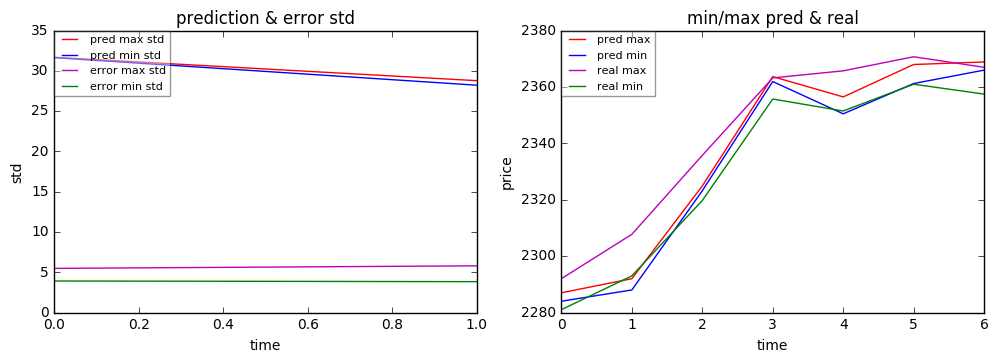

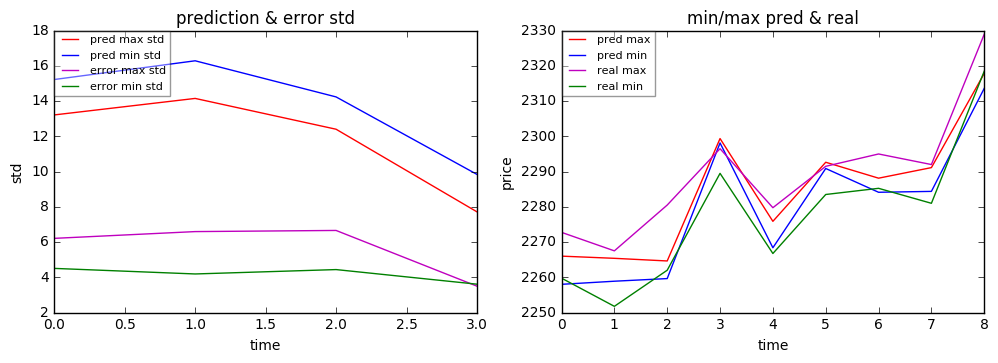

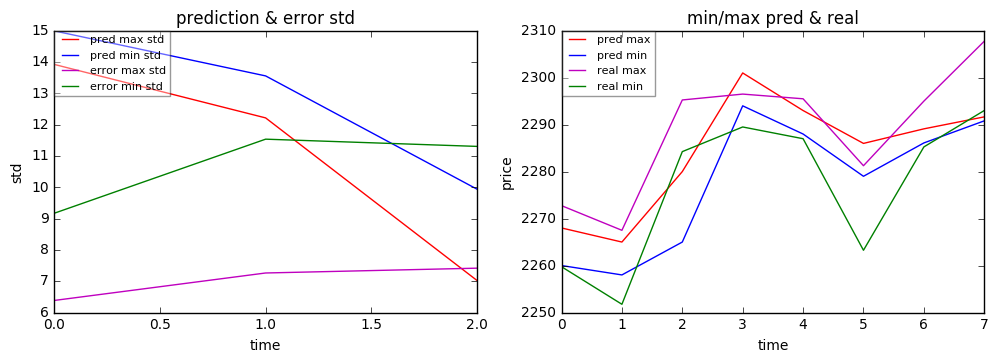

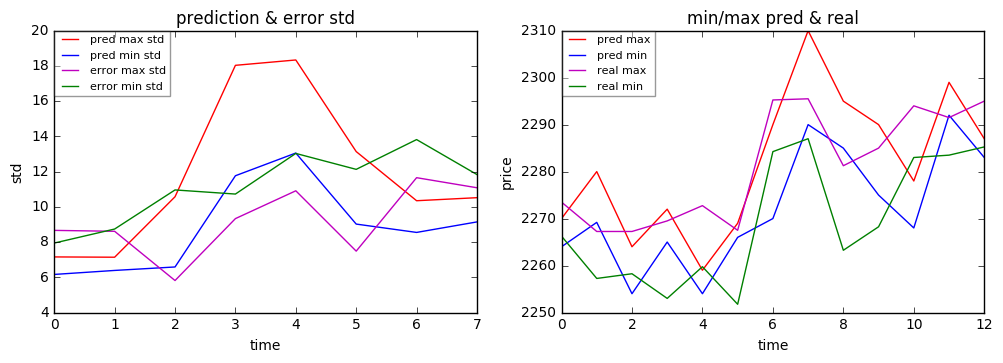

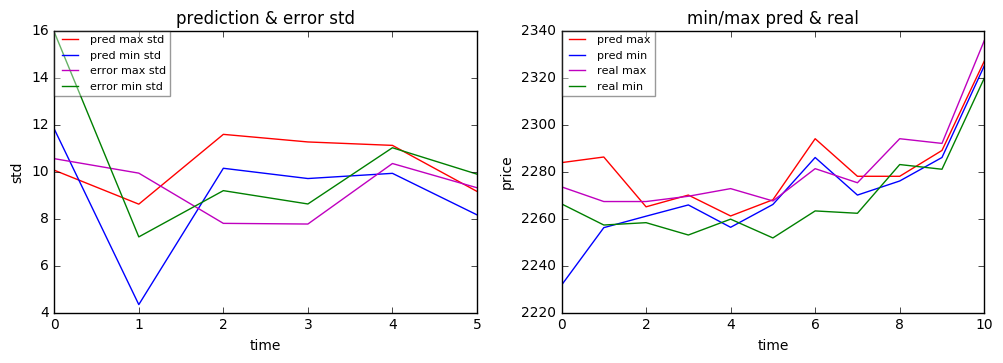

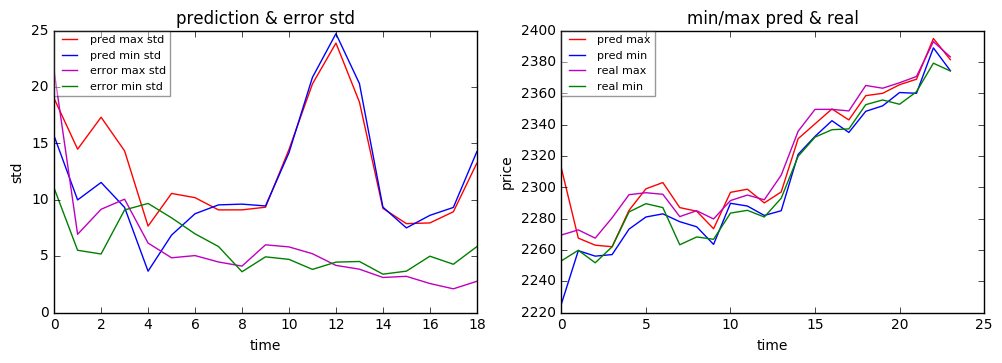

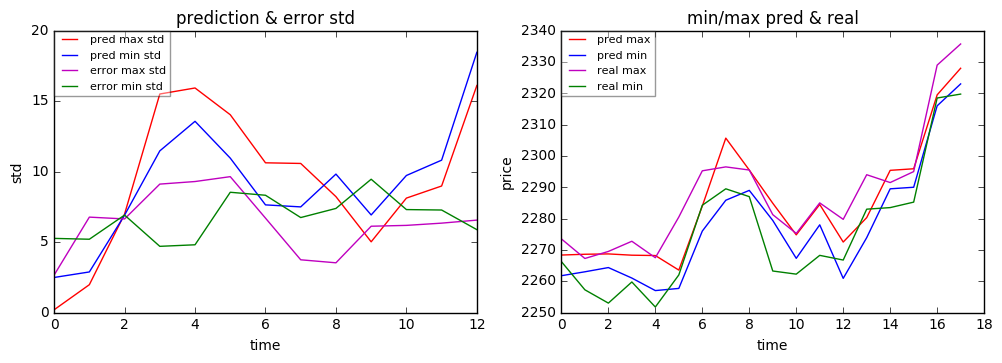

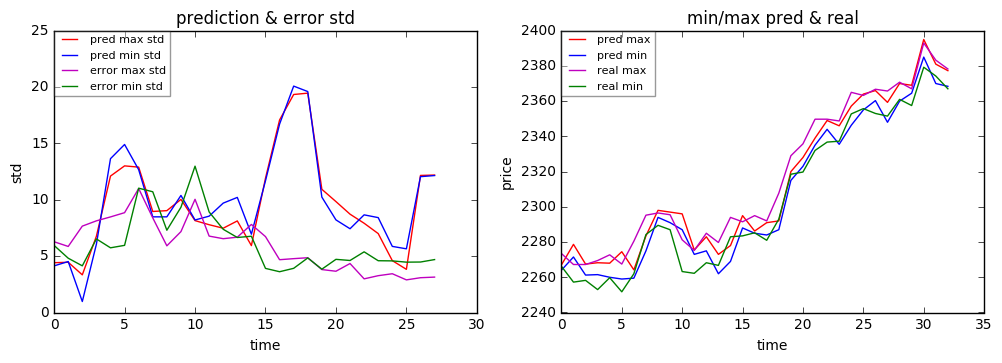

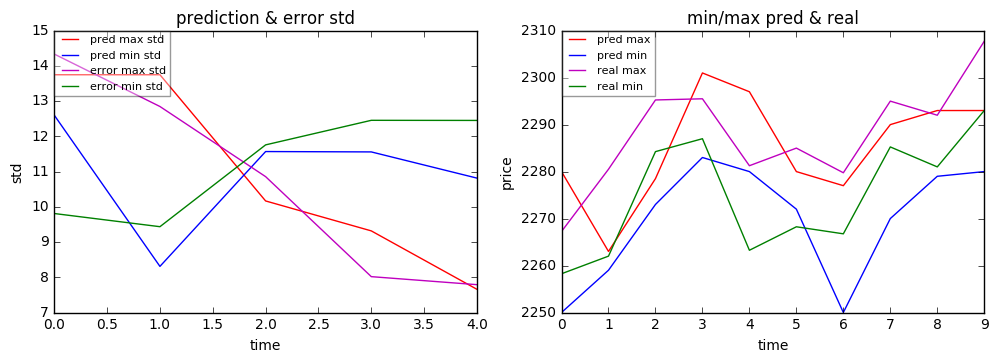

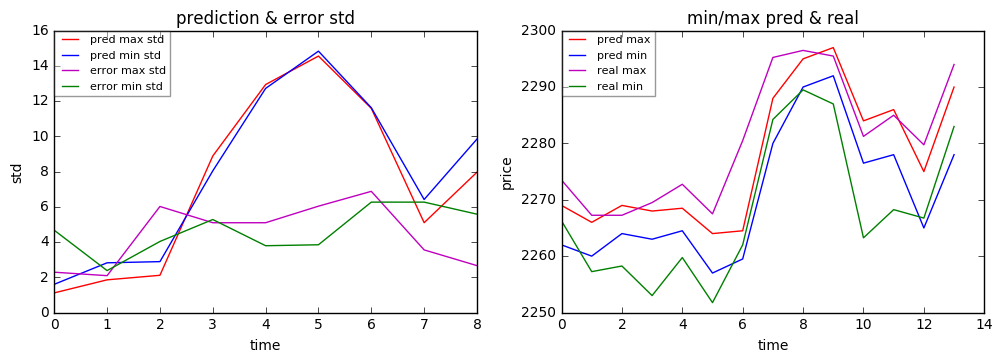

In [146]:
data = pd.DataFrame.from_csv('filtered_data.csv').sort_values(by='event_finished_at').groupby('user_id')
seq = 5
for d in data:
    if len(d[1]['prediction_max'].values) < seq + 2:
        continue
    max_ = d[1]['prediction_max'].values
    min_ = d[1]['prediction_min'].values
    max_err = (d[1]['real_max'] - d[1]['prediction_max']).values
    min_err = (d[1]['real_min'] - d[1]['prediction_min']).values
    max_std, min_std = [], []
    max_err_std, min_err_std = [], []
    for i in range(len(max_) - seq):
        max_std.append(np.std(max_[i:i + seq]))
        min_std.append(np.std(min_[i:i + seq]))
        max_err_std.append(np.std(max_err[i:i + seq]))
        min_err_std.append(np.std(min_err[i:i + seq]))
    plt.figure(figsize=(12,8))
    plt.subplot(221)
    plt.title('prediction & error std')
    plt.ylabel('std')
    plt.xlabel('time')
    plt.plot(max_std, color='r', label='pred max std')
    plt.plot(min_std, color='b', label='pred min std')
    plt.plot(max_err_std, color='m', label='error max std')
    plt.plot(min_err_std, color='g', label='error min std')
    plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., prop={'size':8}).get_frame().set_alpha(0.4)
    plt.subplot(222)
    plt.title('min/max pred & real')
    plt.ylabel('price')
    plt.xlabel('time')
    plt.plot(np.arange(len(max_)), d[1]['prediction_max'], color='r', label='pred max')
    plt.plot(np.arange(len(max_)), d[1]['prediction_min'], color='b', label='pred min')
    plt.plot(np.arange(len(max_)), d[1]['real_max'], color='m', label='real max')
    plt.plot(np.arange(len(max_)), d[1]['real_min'], color='g', label='real min')
    plt.legend(bbox_to_anchor=(0, 1), loc=2, borderaxespad=0., prop={'size':8}).get_frame().set_alpha(0.4)
    plt.show()